In [6]:
import pickle 
import pandas as pd 
import seaborn as sns
import numpy as np 
import json
import itertools
import lifelines
import glob
import os
import copy
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.cm as cm
from matplotlib.colors import Normalize, LinearSegmentedColormap
import matplotlib.patches as patches
from matplotlib.patches import Patch, Rectangle
from matplotlib.lines import Line2D
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import logrank_test
import sys
import scipy.stats

my_path = "/Users/jdf36/Desktop/bwh/cancer_regions/src/"

sys.path.insert(1, my_path)
from jenks import load_clinvar_df, getJenksBreaks, altered_generate_coding_position_list
from utils import place_position
from survival_tools import (
    annotate_region_diagram_ax, 
    get_km_curve_ax,
    risk_ratio,
    get_pfam_domains,
    get_single_gene_and_breaks,
    make_hr_lr_binary_diagram,
    get_colors,
    position_in_pfam_lists,
    get_pfam_domains,
    get_annotated_pfam_profiles,
    get_logrank_p,
    get_annotated_hr_lr_regions,
    get_pfam_comparison_logrank_vals
)
from annotate_funtional_assays import get_functional_from_key
from cosmic import get_cosmic_ratios, get_gene_cosmic, get_cosmic_ratios_altered
from config import gene_to_end_position, src_path


In [7]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

def get_logrank_text(T1,T2,E1,E2):
    logrank = logrank_test(
        T1,
        T2,
        event_observed_A=E1,
        event_observed_B=E2
    )
    logrank_p = logrank.p_value
    p_string = "$logrank \ p \ = " + str(round(logrank_p, 4)) + "$"
    if logrank_p < 0.0001:
        sci_notation_pieces = "{:.2e}".format(logrank_p).split("e")
        exponent = int(sci_notation_pieces[1])
        decimal = sci_notation_pieces[0]
        p_string = "$logrank \ p \ = " + decimal + " x 10^{" + str(exponent) + "}" +  "$"
        
    return p_string

def format_p_string(p):
    p_string = str(round(p, 4))
    if p < 0.0001:
        sci_notation_pieces = "{:.2e}".format(p).split("e")
        exponent = int(sci_notation_pieces[1])
        decimal = sci_notation_pieces[0]
        p_string =  "$" + decimal + "x10^{" + str(exponent) + "}" +  "$"
        return p_string
    return "$" + p_string + "$"

In [8]:
file = open("../gene_to_df_delet_removed_092922.pickle",'rb')
gene_to_df = pickle.load(file)
logrank_df = pd.read_csv("../all_logrank_df_092922.csv")
regression_results = pd.read_csv("../regression_results_delet_removed_092922.csv", index_col = 0)
file = open("../mega_results_checkppoint_092922.pickle",'rb')
mega_file = pickle.load(file)

In [9]:
total_participants = set()
for g, gene_df in gene_to_df.items():
    total_participants = total_participants.union(set(gene_df.index.values))
    
print(len(total_participants))

brca1_domains = get_pfam_domains("BRCA1")
RING_coords = brca1_domains["Zinc finger, C3HC4 type (RING finger)"][0]
print((RING_coords[1] - RING_coords[0]) / 3)

109581
40.0


ATM 1.17[1.06,1.28] 0.0112 0.0004
BRCA1 0.95[0.79,1.12] 0.3351 6.41 x 10^{-5}
BRCA2 0.96[0.85,1.07] 0.4171 4.67 x 10^{-7}
$4.93x10^{-5}$
CHEK2 1.37[1.19,1.56] $4.93x10^{-5}$ 0.0032
MSH6 0.85[0.68,1.01] 0.0331 0.0083
PALB2 1.09[0.9,1.28] 0.5955 0.0042
TP53 1.1[0.72,1.48] 0.8799 0.0103


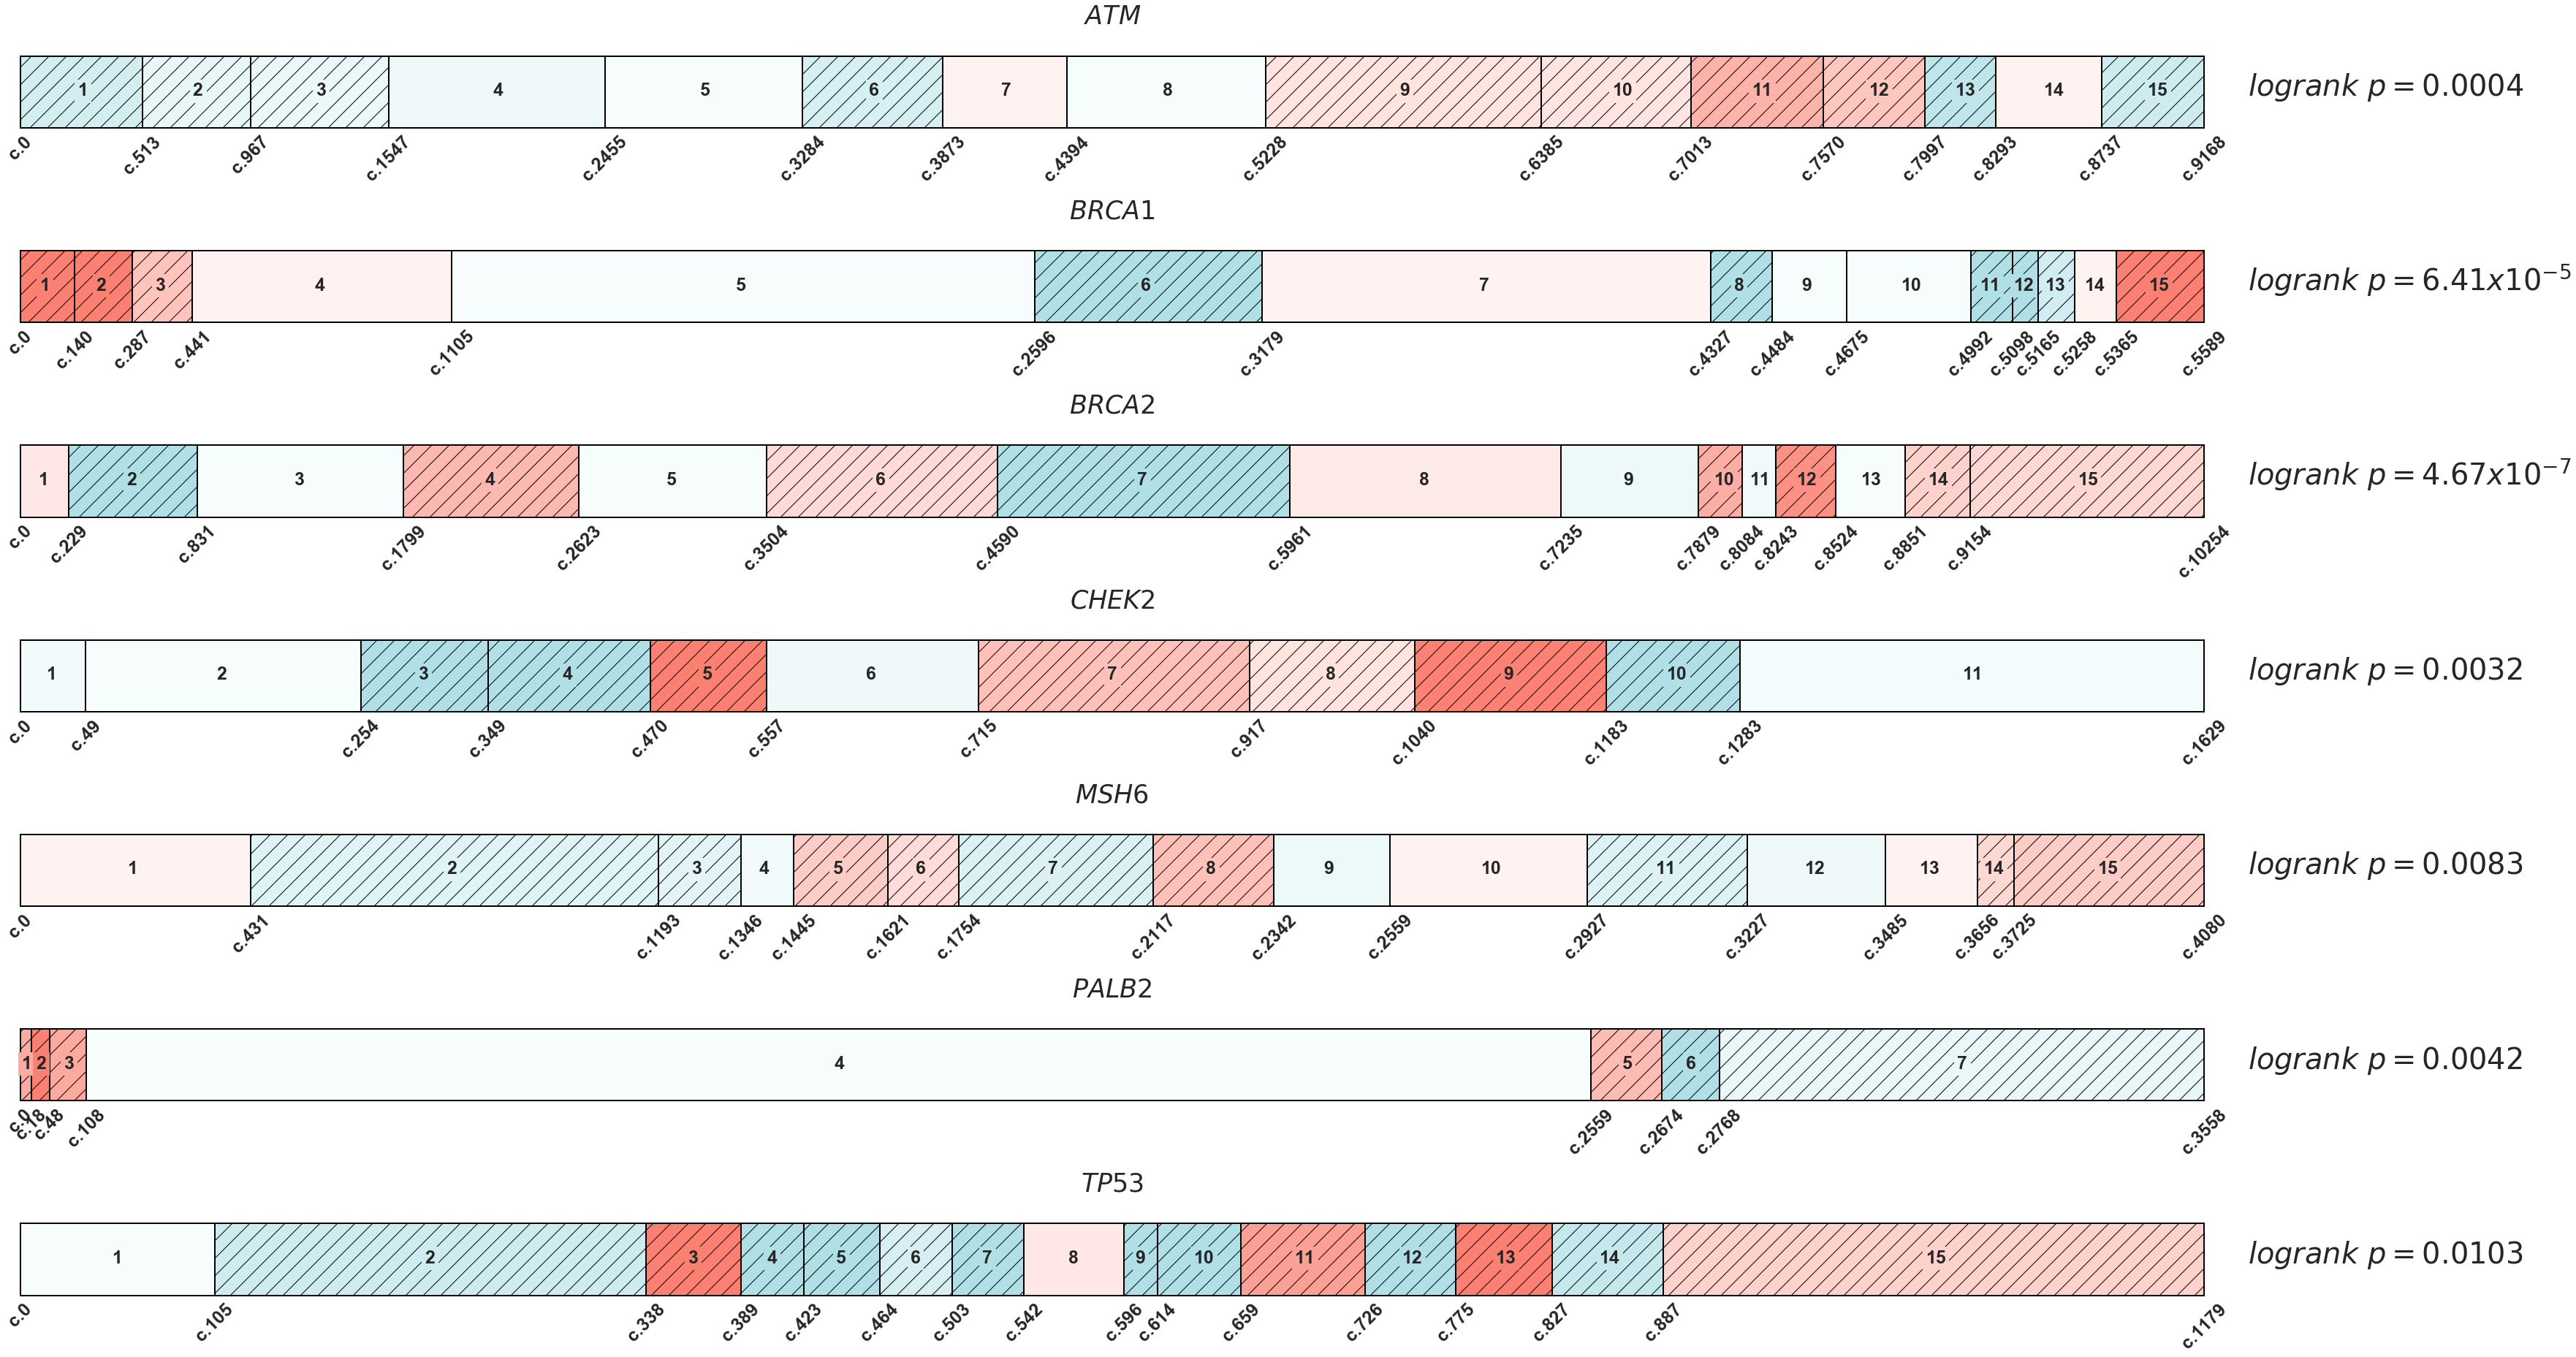

In [10]:
keys = [
    "ATM_15_0.15",
    "BRCA1_15_0.15",
    "BRCA2_15_0.15",
    "CHEK2_11_0.15",
    "MSH6_15_0.15",
    "PALB2_7_0.15",
    "TP53_15_0.15"
]

genes_for_diagram = [
    "ATM", "BRCA1", "BRCA2", "CHEK2", "MSH6", "PALB2", "TP53"
]

fig, axes = plt.subplots(
    len(genes_for_diagram), 
    1, 
    figsize = (len(genes_for_diagram) * 7, len(genes_for_diagram)*3.7)
)

gene_to_text_offset = {
    "BRCA1" :  20,
    "BRCA2" : 30,
    "CHEK2" : 5,
    "TP53" : 3,
    "MSH6" :15,
    "PALB2" : 7,
    "ATM" : 15
}

for i, ax in enumerate(axes):
    gene = genes_for_diagram[i]
    key = keys[i]
    optimal = logrank_df.loc[logrank_df["key"] == key].iloc[0]
    hr_regions = list(map(lambda x : int(x), optimal["high_regions"].split("|")))
    lr_regions = list(map(lambda x : int(x), optimal["low_regions"].split("|")))
    breakpoints = list(map(lambda x : float(x), optimal["breakpoints"].split("|")))
    breakpoints[-1] = gene_to_end_position[gene]
    
    
    missense_weight = regression_results.loc[gene]["Missense exp(coef)"]

    cmap = LinearSegmentedColormap.from_list('mycmap', ['powderblue', 'white', 'salmon'])
    norm = Normalize(vmin=-1, vmax=1)

    colors = []
    for j in range(1, optimal["breaks"] + 1):
        v = mega_file[gene][optimal["breaks"]][j]
        weight = np.log2(v["exp(coef)"] / missense_weight)
        min_veight_low = -0.1
        min_weight_high = 0.1
        if weight > min_veight_low and weight < 0:
            weight = min_veight_low
        if weight < min_weight_high and weight > 0:
            weight = min_weight_high
        color =  cmap(norm(weight))
        color_hex = matplotlib.colors.to_hex(color)
        colors.append(color)
        
    make_hr_lr_binary_diagram(
        gene,
        breakpoints, 
        hr_regions, 
        lr_regions, 
        colors,
        dist_offset = gene_to_text_offset[gene], 
        ax = ax, 
        annotate_pfam = False
    )  
    
    gene = genes_for_diagram[i]
    best_val = logrank_df.loc[logrank_df["key"] == key].iloc[0]
    high_regions = list(map(lambda x : int(x), best_val["high_regions"].split("|")))
    low_regions = list(map(lambda x : int(x), best_val["low_regions"].split("|")))
    breakpoints = list(map(lambda x : int(float(x)), best_val["breakpoints"].split("|")))
    breakpoints[-1] = gene_to_end_position[gene]
    gene_region_df = get_annotated_hr_lr_regions(
        gene, 
        breakpoints, 
        high_regions, 
        low_regions, 
        gene_to_df_loc = my_path + "gene_to_df_delet_removed_092922.pickle"
    )
    s1 = gene_region_df.loc[gene_region_df["high_region_carrier"] == 1]
    s2 = gene_region_df.loc[gene_region_df["low_region_carrier"] == 1]
    
    E1 = s1["breastcancer"].values
    T1 = s1["breastcancer_age"].values

    E2 = s2["breastcancer"].values
    T2 = s2["breastcancer_age"].values
    
    rr = risk_ratio(s1, s2, return_confidence = True, t = 65)
    logrank = logrank_test(
        T1,
        T2,
        event_observed_A=E1,
        event_observed_B=E2
    )
    logrank_p = logrank.p_value
    p_string_0 = str(round(logrank_p, 4))
    if logrank_p < 0.0001:
        sci_notation_pieces = "{:.2e}".format(logrank_p).split("e")
        exponent = int(sci_notation_pieces[1])
        decimal = sci_notation_pieces[0]
        p_string_0 =  decimal + " x 10^{" + str(exponent) + "}" 
    ax.text(breakpoints[-1] * 1.02, 0.45, r"$logrank \ p = " +  p_string_0 + "$", fontsize = 40)
    non_carriers = gene_region_df.loc[
        gene_region_df["Missense"] == 0
    ]

    E4 = non_carriers["breastcancer"].values
    T4 = non_carriers["breastcancer_age"].values

    all_missense_carriers = gene_region_df.loc[gene_region_df["Missense"] == 1]
    E5 = all_missense_carriers["breastcancer"].values
    T5 = all_missense_carriers["breastcancer_age"].values
    
    rr = risk_ratio(all_missense_carriers, non_carriers, return_confidence = True, t = 65)
#     print(rr)

    logrank = logrank_test(
        T5,
        T4,
        event_observed_A=E5,
        event_observed_B=E4
    )
    
    logrank_p = logrank.p_value
    p_string = str(round(logrank_p, 4))
    if logrank_p < 0.0001:
        sci_notation_pieces = "{:.2e}".format(logrank_p).split("e")
        exponent = int(sci_notation_pieces[1])
        decimal = sci_notation_pieces[0]
        p_string =  "$" + decimal + "x10^{" + str(exponent) + "}" +  "$"
        print(p_string)
    
    print(gene , str(rr[0]) + "[" + str(rr[1]) +  "," + str(rr[2]) + "]", p_string, p_string_0)
    
    
fig.tight_layout()

# fig.savefig("./high_res_figures/092922_Fig2A.png", bbox_inches = "tight")


ATM 0.1 15 1.5[1.23,1.78] 0.0002

BRCA1 0.15 14 3.48[2.67,4.28] 6.41 x 10^{-5}

BRCA2 0.35 15 2.94[2.35,3.54] 2.13 x 10^{-7}

CHEK2 0.05 9 1.96[1.56,2.36] 0.0002

MSH6 0.1 15 1.67[1.31,2.03] 0.0065

PALB2 0.15 7 2.0[1.44,2.56] 0.0042

TP53 0.35 15 2.62[1.63,3.6] 0.0043


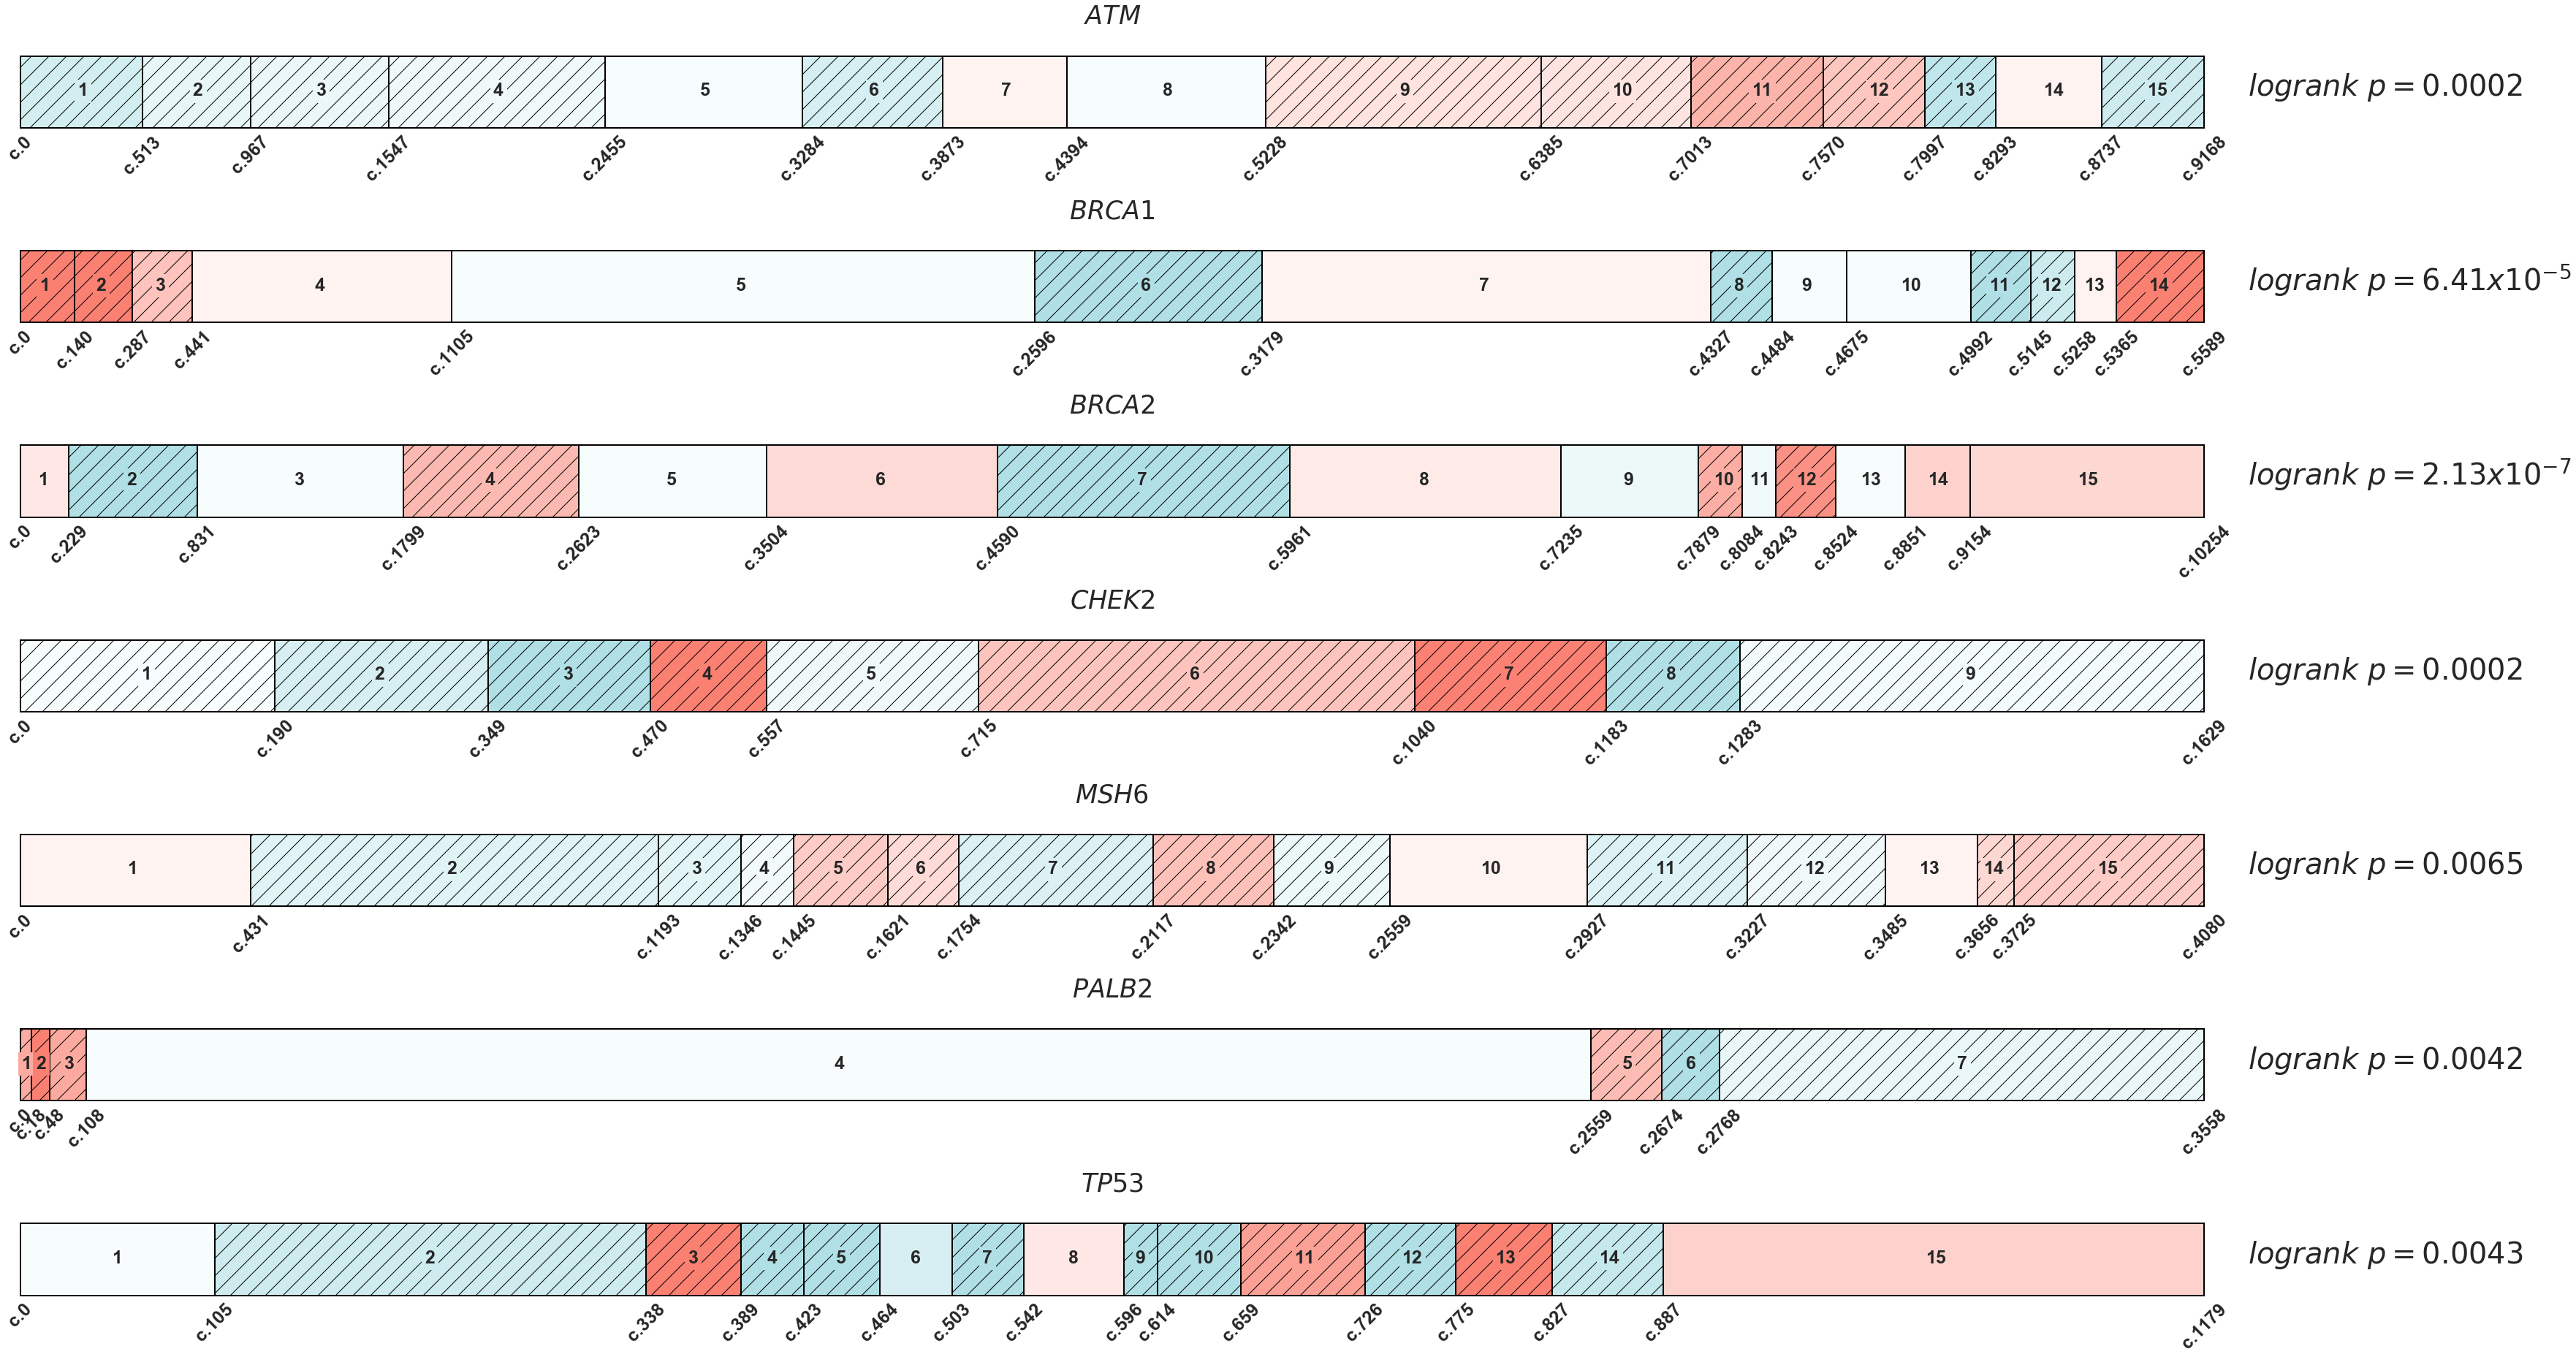

In [11]:
fig, axes = plt.subplots(
    len(genes_for_diagram), 
    1, 
    figsize = (len(genes_for_diagram) * 7, len(genes_for_diagram)*3.7)
)


gene_to_text_offset = {
    "BRCA1" :  20,
    "BRCA2" : 30,
    "CHEK2" : 5,
    "TP53" : 3,
    "MSH6" :15,
    "PALB2" : 7,
    "ATM" : 15
}

for i, gene in enumerate(genes_for_diagram):
    ax = axes[i]
    gene_df = logrank_df.loc[logrank_df["gene"] == gene].sort_values(by = "p")
    optimal = gene_df.iloc[0]
    print()
    k = best_val.name
    hr_regions = list(map(lambda x : int(x), optimal["high_regions"].split("|")))
    lr_regions = list(map(lambda x : int(x), optimal["low_regions"].split("|")))
    breakpoints = list(map(lambda x : float(x), optimal["breakpoints"].split("|")))
    breakpoints[-1] = gene_to_end_position[gene]
    dist_offset = 15
    if breakpoints[-1] < 5000:
        dist_offset = 3
        
    missense_weight = regression_results.loc[gene]["Missense exp(coef)"]

    cmap = LinearSegmentedColormap.from_list('mycmap', ['powderblue', 'white', 'salmon'])
    norm = Normalize(vmin=-1, vmax=1)

    colors = []
    for j in range(1, optimal["breaks"] + 1):
        v = mega_file[gene][optimal["breaks"]][j]
        weight = np.log2(v["exp(coef)"] / missense_weight)
        min_veight_low = -0.1
        min_weight_high = 0.1
        if weight > min_veight_low and weight < 0:
            weight = min_veight_low
        if weight < min_weight_high and weight > 0:
            weight = min_weight_high
        color =  cmap(norm(weight))
        color_hex = matplotlib.colors.to_hex(color)
        colors.append(color)
        
    
    make_hr_lr_binary_diagram(
        gene,
        breakpoints, 
        hr_regions, 
        lr_regions, 
        colors,
        dist_offset = gene_to_text_offset[gene], 
        ax = ax, 
        annotate_pfam = False
    )  
    
    best_val = gene_df.iloc[0]
    high_regions = list(map(lambda x : int(x), best_val["high_regions"].split("|")))
    low_regions = list(map(lambda x : int(x), best_val["low_regions"].split("|")))
    breakpoints = list(map(lambda x : int(float(x)), best_val["breakpoints"].split("|")))
    breakpoints[-1] = gene_to_end_position[gene]
    gene_region_df = get_annotated_hr_lr_regions(
        gene, 
        breakpoints, 
        high_regions, 
        low_regions, 
        gene_to_df_loc = my_path + "gene_to_df_delet_removed_092922.pickle"
    )
    
    s1 = gene_region_df.loc[gene_region_df["high_region_carrier"] == 1]
    s2 = gene_region_df.loc[gene_region_df["low_region_carrier"] == 1]
    
    E1 = s1["breastcancer"].values
    T1 = s1["breastcancer_age"].values

    E2 = s2["breastcancer"].values
    T2 = s2["breastcancer_age"].values
    
    rr1 = risk_ratio(s1, s2, return_confidence = True, t = 65)
#     print(rr)

    logrank = logrank_test(
        T1,
        T2,
        event_observed_A=E1,
        event_observed_B=E2
    )
    
    logrank_p = logrank.p_value
    p_string_0 = str(round(logrank_p, 4))
    if logrank_p < 0.0001:
        sci_notation_pieces = "{:.2e}".format(logrank_p).split("e")
        exponent = int(sci_notation_pieces[1])
        decimal = sci_notation_pieces[0]
        p_string_0 =   decimal + " x 10^{" + str(exponent) + "}"
    
    ax.text(breakpoints[-1] * 1.02, 0.45, "$logrank \ p = " +  p_string_0 + "$", fontsize = 40)
#     print(gene, str(rr[0]) + "[" + str(rr[1]) +  "," + str(rr[2]) + "]", p_string)
    
    
    
    non_carriers = gene_region_df.loc[
        gene_region_df["Missense"] == 0
    ]

    E4 = non_carriers["breastcancer"].values
    T4 = non_carriers["breastcancer_age"].values

    all_missense_carriers = gene_region_df.loc[gene_region_df["Missense"] == 1]
    E5 = all_missense_carriers["breastcancer"].values
    T5 = all_missense_carriers["breastcancer_age"].values
    
    rr = risk_ratio(all_missense_carriers, non_carriers, return_confidence = True, t = 65)
#     print(rr)

    logrank = logrank_test(
        T5,
        T4,
        event_observed_A=E5,
        event_observed_B=E4
    )
    
    logrank_p = logrank.p_value
    p_string = str(round(logrank_p, 4))
    if logrank_p < 0.0001:
        sci_notation_pieces = "{:.2e}".format(logrank_p).split("e")
        exponent = int(sci_notation_pieces[1])
        decimal = sci_notation_pieces[0]
        p_string =  "$" + decimal + "x10^{" + str(exponent) + "}" +  "$"
    
    print(gene, best_val["hr_diff"], best_val["breaks"], str(rr1[0]) + "[" + str(rr1[1]) +  "," + str(rr1[2]) + "]", p_string_0)
    
fig.tight_layout()

# fig.savefig("./high_res_figures/092922_FigS5A.png", bbox_inches = "tight")

Text(0.4, 0.17, '$\\it{log_2} \\ ( \\ \\frac{Regional \\ Hazard \\ Ratio}{Missense\\ Hazard\\ Ratio} ) $')

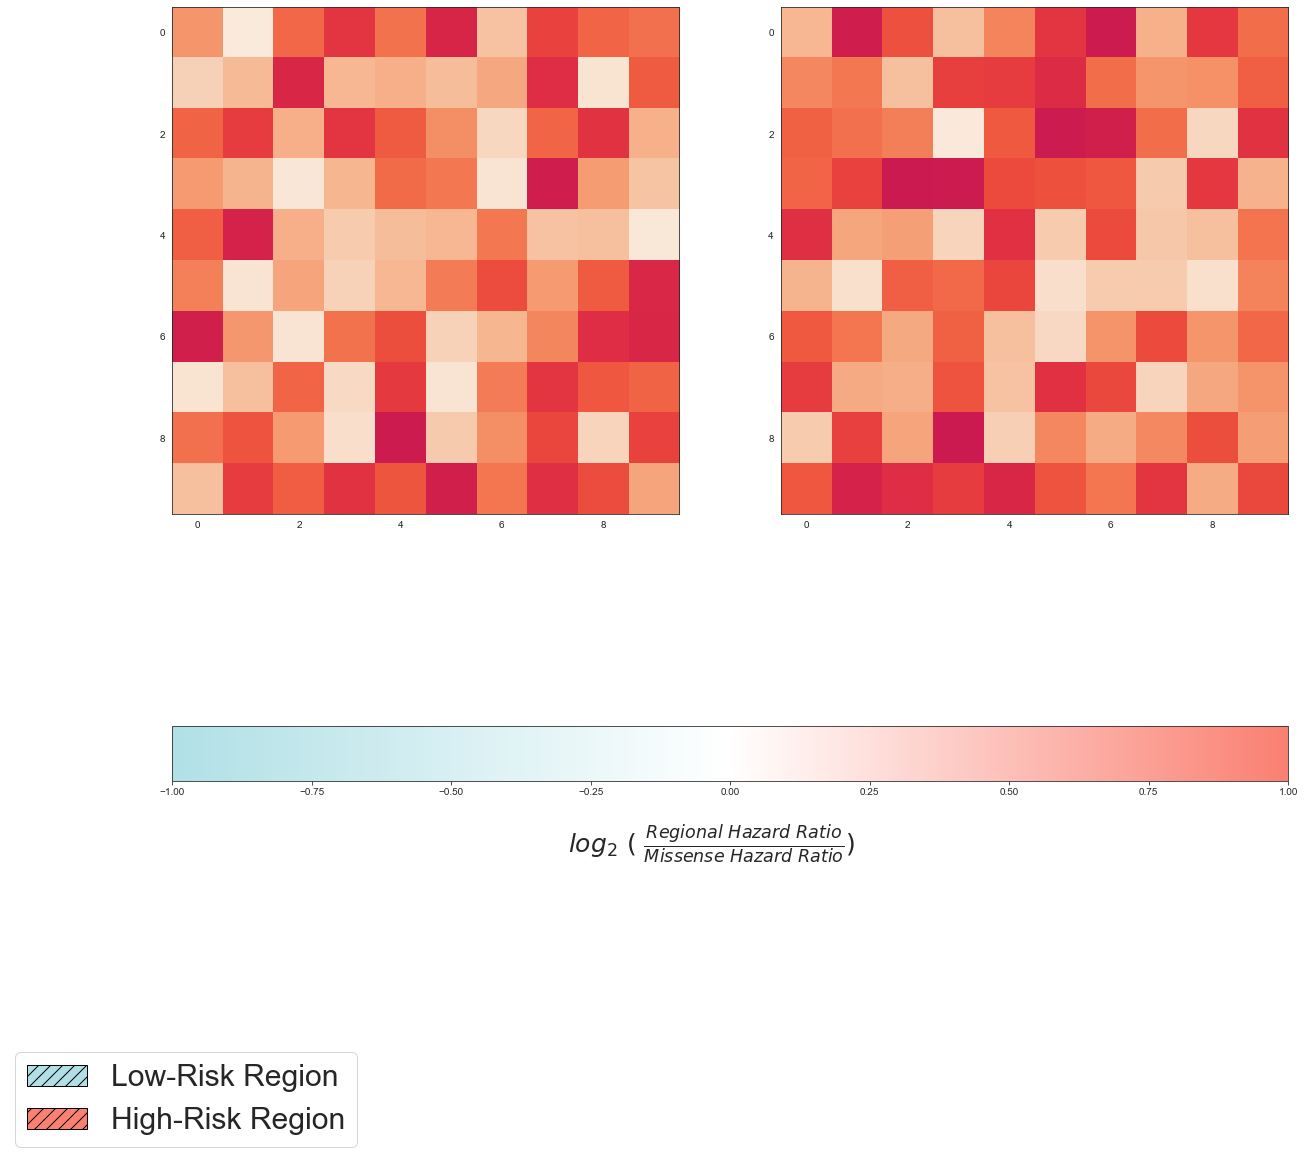

In [12]:
cmap = LinearSegmentedColormap.from_list('mycmap', ['powderblue', "white", 'salmon'])
norm = Normalize(vmin=-1, vmax=1)



fig, axes = plt.subplots(1, 2, figsize = (20, len(genes_for_diagram)*3.7))
  
for ax in axes.flat:
    im = ax.imshow(np.random.random((10, 10)), vmin=-1, vmax=1)
  
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, cmap=cmap, ax=axes.ravel().tolist(), orientation = "horizontal")


patch1 = patches.Patch(
    facecolor='powderblue', 
    edgecolor='black',
    label='Low-Risk Region', 
    hatch = r"//",
)

patch2 = patches.Patch(
    facecolor='salmon', 
    edgecolor='black',
    label='High-Risk Region', 
    hatch = r"//",
)
legend_elements = [patch1, patch2]

fig.legend(handles=legend_elements, loc='lower left', fontsize = 30)


fig.text(0.4,0.17,r"$\it{log_2} \ ( \ \frac{Regional \ Hazard \ Ratio}{Missense\ Hazard\ Ratio} ) $", fontsize = 25)
# fig.savefig("./high_res_figures/legend_elements.png", bbox_inches = "tight")

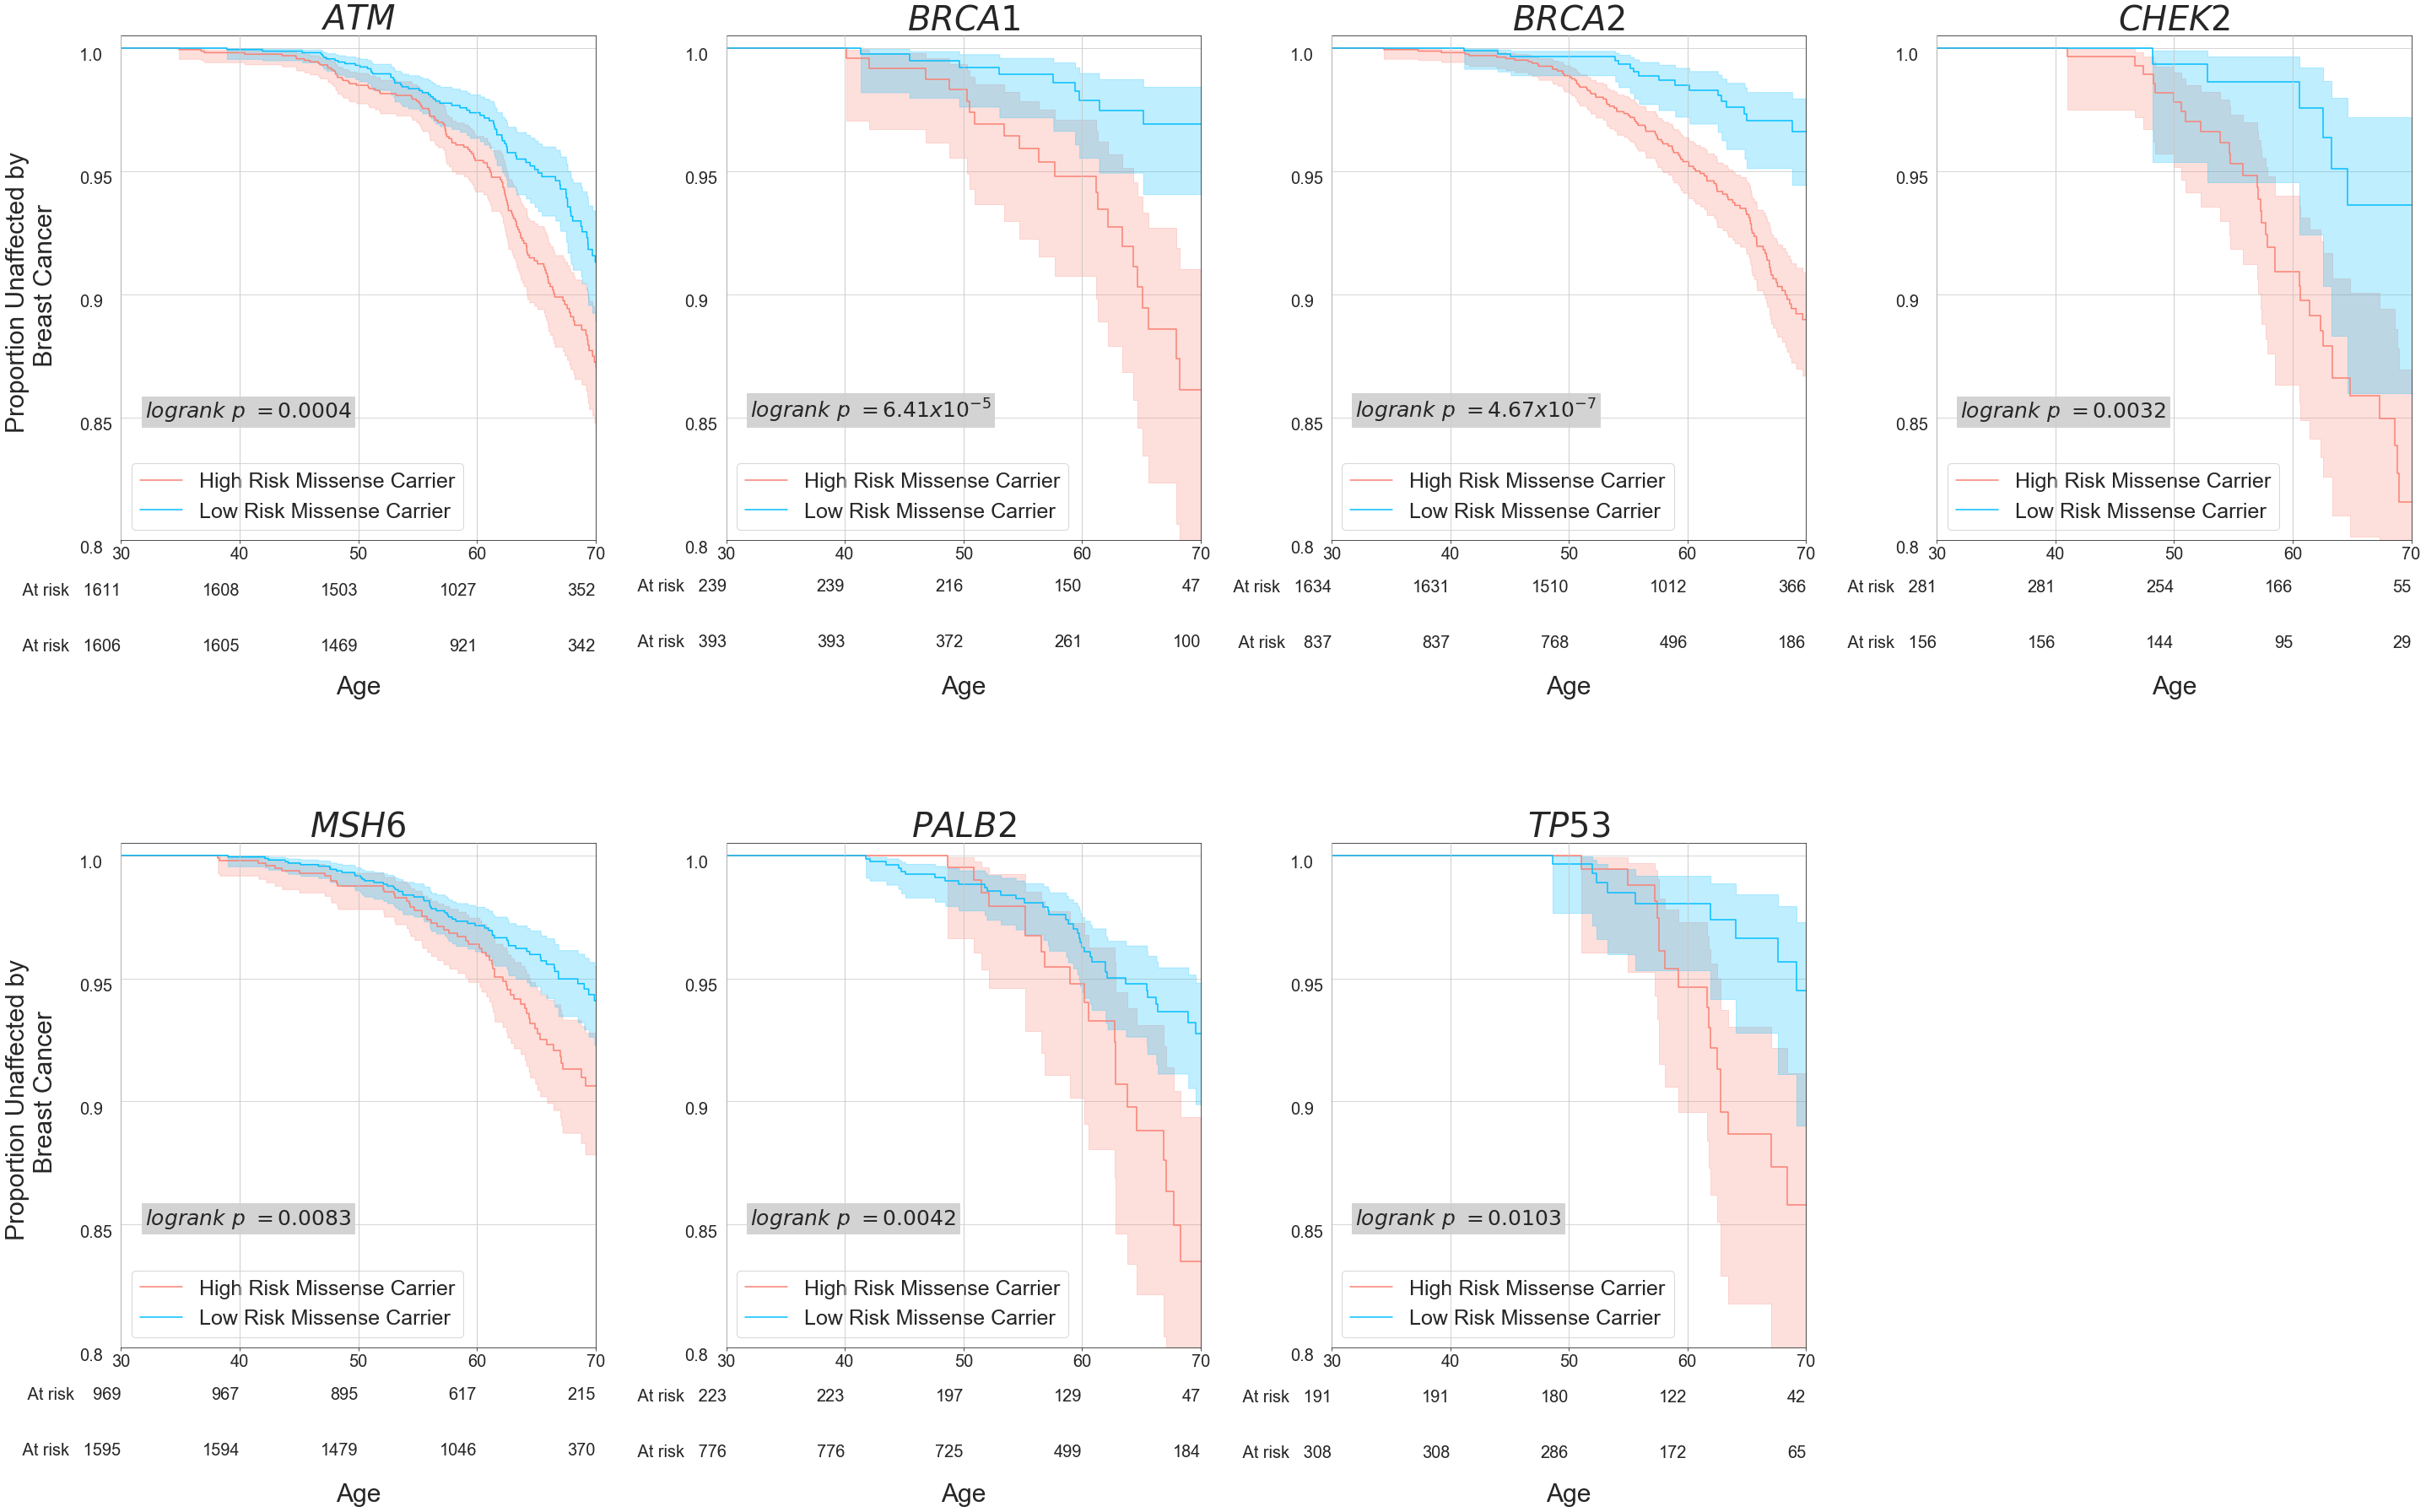

In [13]:
fig, ((ax1,ax2,ax3, ax4),(ax5,ax6, ax7, ax8)) = plt.subplots(2, 4, figsize = (40,25))

# fig.subplots_adjust(bottom = 0.6, hspace = 1)

axes = [ax1,ax2,ax3, ax4, ax5, ax6, ax7, ax8]

# genes_for_diagram = ["BARD1", "BRCA1", "BRCA2", "MSH2", "TP53"]
# keys = ["BARD1_9_0.35", "BRCA1_15_0.1", "BRCA2_6_0.1", "MSH2_5_0.05", "TP53_7_0.35"]

genes_for_diagram = ["BRCA1", "BRCA2", "CHEK2"]
keys = [
    "ATM_15_0.15",
    "BRCA1_15_0.15",
    "BRCA2_15_0.15",
    "CHEK2_11_0.15",
    "MSH6_15_0.15",
    "PALB2_7_0.15",
    "TP53_15_0.15"
]


for i, key in enumerate(keys):
    ax = axes[i]
    gene = key.split("_")[0]
    optimal = logrank_df.loc[logrank_df["key"] == key].iloc[0]
    hr_regions = list(map(lambda x : int(x), optimal["high_regions"].split("|")))
    lr_regions = list(map(lambda x : int(x), optimal["low_regions"].split("|")))
    breakpoints = list(map(lambda x : float(x), optimal["breakpoints"].split("|")))
    breakpoints[-1] =  gene_to_end_position[gene]
    best_val = logrank_df.loc[logrank_df["key"] == key].iloc[0]
    high_regions = list(map(lambda x : int(x), best_val["high_regions"].split("|")))
    low_regions = list(map(lambda x : int(x), best_val["low_regions"].split("|")))
    breakpoints = list(map(lambda x : int(float(x)), best_val["breakpoints"].split("|")))
    breakpoints[-1] =  gene_to_end_position[gene]
    gene_region_df = get_annotated_hr_lr_regions(
        gene, 
        breakpoints, 
        high_regions, 
        low_regions, 
        gene_to_df_loc = my_path + "gene_to_df_delet_removed_092922.pickle"
    )

    logrank_subset = logrank_df.loc[logrank_df["gene"] == gene].sort_values(by = "p")

    s1 = gene_region_df.loc[gene_region_df["high_region_carrier"] == 1]
    s2 = gene_region_df.loc[gene_region_df["low_region_carrier"] == 1]
    

    E1 = s1["breastcancer"].values
    T1 = s1["breastcancer_age"].values

    E2 = s2["breastcancer"].values
    T2 = s2["breastcancer_age"].values
    
    show_at_risk_counts = True
    at_risk_y_offset = -10
   
    get_km_curve_ax(
        axes[i], 
        T1,
        T2,
        E1,
        E2,
        label_group_1 = "High Risk Missense Carrier",
        label_group_2 = "Low Risk Missense Carrier",
        color_group_1 = "salmon",
        color_group_2 = "deepskyblue",
#         title = "$\it{" + gene + "}$",
        show_logrank = False,
        show_at_risk_counts = True,
        x_tick_plot = [30,40,50,60,70],
        at_risk_y_offset = at_risk_y_offset,
        legend_fontsize = 25, 
        use_xlabel = False,
        use_ylabel = False 
    )
    
    ax.set_title("$\it{" + gene + "}$", fontsize=40)
    ax.set_ylim(bottom = 0.8, top = 1.005)
    ax.set_yticks([0.8,0.85,0.9,0.95,1.0])
#     ax.set_yticklabels([0.8,0.85,0.9,0.95,1.0], fontsize = 20)
    ax.axes.yaxis.set_ticklabels([])
    for i in [0.8,0.85,0.9,0.95,1.0]:
        ax.text(26.5, i-0.005, str(i), fontsize = 20)
        
    ax.set_xticks([30,40,50,60,70])
    ax.set_xticklabels([30,40,50,60,70], fontsize = 20)
    ax.set_ylabel("", fontsize = 30)
#     rr = 
    ax.set_xlabel("\n\n\n\nAge", fontsize = 30)
    logrank_text = get_logrank_text(T1,T2,E1,E2)
    ax.text(32,0.85, logrank_text, bbox={"color": "lightgray"}, fontsize = 25)
   

ax1.set_ylabel("Proportion Unaffected by \n Breast Cancer\n\n", fontsize = 30)
ax5.set_ylabel("Proportion Unaffected by \n Breast Cancer\n\n", fontsize = 30)
fig.subplots_adjust(hspace = 0.6)
ax8.remove()
# fig.tight_layout()

# fig.savefig("./high_res_figures/092922_FigS1.png", bbox_inches = "tight")

HR/LR ATM (1.58, 1.27, 1.9, 811, 693, [[100, 711], [54, 639]]) 0.0003826510825960862
HR/NC ATM (1.41, 1.22, 1.59, 811, 49968, [[100, 711], [4374, 45594]]) 6.6014150491003496e-06
Mis/NC ATM (1.17, 1.06, 1.28, 3058, 49968, [[313, 2745], [4374, 45594]]) 0.011233219808104029
HR/LR BRCA1 (3.48, 2.67, 4.28, 118, 193, [[17, 101], [8, 185]]) 6.405202613673583e-05
HR/NC BRCA1 (1.63, 1.19, 2.07, 118, 51734, [[17, 101], [4582, 47152]]) 0.01332487572621266
Mis/NC BRCA1 (0.95, 0.79, 1.12, 1552, 51734, [[131, 1421], [4582, 47152]]) 0.3350687554613393
HR/LR BRCA2 (2.51, 1.98, 3.05, 806, 366, [[83, 723], [15, 351]]) 4.670595533711556e-07
HR/NC BRCA2 (1.16, 0.96, 1.37, 806, 49464, [[83, 723], [4377, 45087]]) 0.007431497040745787
Mis/NC BRCA2 (0.96, 0.85, 1.07, 3667, 49464, [[313, 3354], [4377, 45087]]) 0.4171462006604375
HR/LR CHEK2 (2.33, 1.5, 3.16, 143, 69, [[29, 114], [6, 63]]) 0.003210694894043478
HR/NC CHEK2 (2.3, 1.98, 2.63, 143, 52536, [[29, 114], [4623, 47913]]) 3.0501139811976944e-08
Mis/NC CH

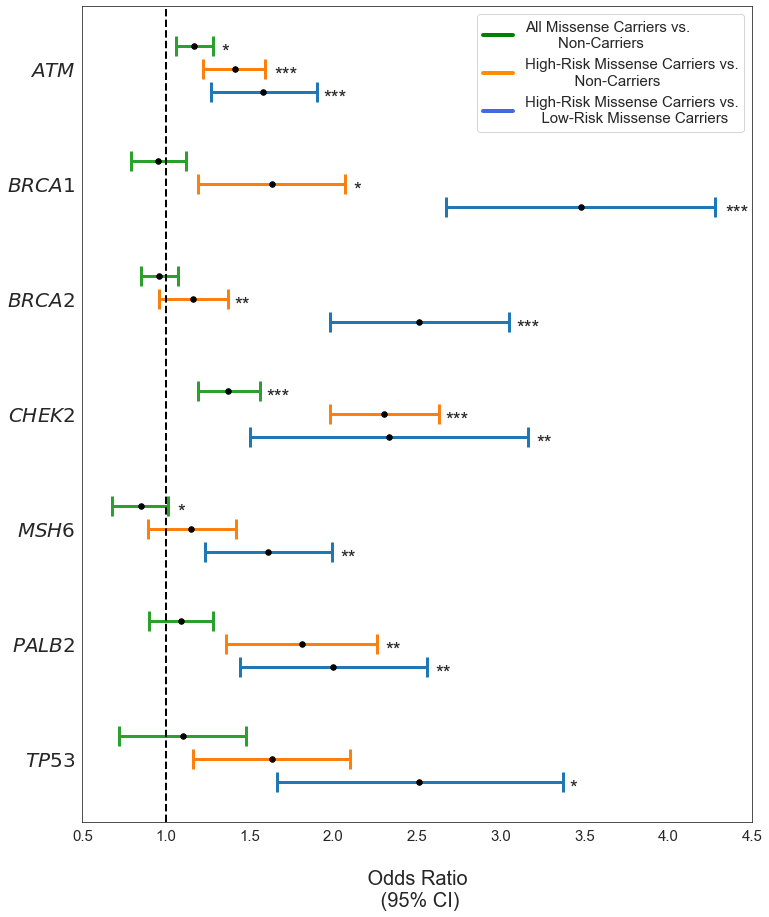

In [14]:
sns.set_style("white")

def df_logrank_test(
    df1, 
    df2, 
    event_col = "breastcancer", 
    duration_col = "breastcancer_age"
):
    T1 =  df1[duration_col].values
    E1 = df1[event_col].values
    T2 =  df2[duration_col].values
    E2 = df2[event_col].values
    
    logrank = logrank_test(
        T1,
        T2,
        event_observed_A=E1,
        event_observed_B=E2
    )
    return logrank.p_value


def get_stars_from_p(p):
    if p > 0.05:
        return None 
    if p > 0.01:
        return "*"
    if p > 0.001:
        return "**"
    if p <= 0.001:
        return "***"


keys = [
    "ATM_15_0.15",
    "BRCA1_15_0.15",
    "BRCA2_15_0.15",
    "CHEK2_11_0.15",
    "MSH6_15_0.15",
    "PALB2_7_0.15",
    "TP53_15_0.15"
]


y = []
x = []
x_err = []
stars = []

genes_for_diagram = ["ATM", "BRCA1", "BRCA2", "CHEK2", "MSH6", "PALB2", "TP53"]

counter = 0 

all_vals = []

for gene, key_of_interest in zip (genes_for_diagram, keys):
    best_val = logrank_df.loc[logrank_df["key"] == key_of_interest].iloc[0]
    high_regions = list(map(lambda x : int(x), best_val["high_regions"].split("|")))
    low_regions = list(map(lambda x : int(x), best_val["low_regions"].split("|")))
    breakpoints = list(map(lambda x : int(float(x)), best_val["breakpoints"].split("|")))
    breakpoints[-1] =  gene_to_end_position[gene]
    
    gene_region_df = get_annotated_hr_lr_regions(
        gene, 
        breakpoints, 
        high_regions, 
        low_regions, 
        gene_to_df_loc = my_path + "gene_to_df_delet_removed_092922.pickle"
    )

    s1 = gene_region_df.loc[gene_region_df["high_region_carrier"] == 1]
    s2 = gene_region_df.loc[gene_region_df["low_region_carrier"] == 1]
     
    gene_df = gene_to_df[gene]
    delet_carriers= gene_df.loc[
        gene_df["Deleterious"] == 1
    ]
    
    non_carriers = gene_region_df.loc[
        gene_region_df["Missense"] == 0
    ]

    E4 = non_carriers["breastcancer"].values
    T4 = non_carriers["breastcancer_age"].values

    all_missense_carriers = gene_region_df.loc[gene_region_df["Missense"] == 1]
    
    E5 = all_missense_carriers["breastcancer"].values
    T5 = all_missense_carriers["breastcancer_age"].values
    
    rr1 = risk_ratio(s1, s2, return_confidence = True, t = 65)
    logrank1 = df_logrank_test(s1, s2)
    y_pos = len(genes_for_diagram) - 1 - counter
    y.append(y_pos - 0.2)
    x.append(rr1[0])
    x_err.append([rr1[0] - rr1[1], rr1[2] - rr1[0]])
    stars.append(get_stars_from_p(logrank1))
    print("HR/LR", gene, rr1, logrank1)
    all_vals.append([gene, "HR/LR", rr1[0], rr[1], rr[2], logrank1])
    rr2 = risk_ratio(s1, non_carriers, return_confidence = True, t = 65)
    logrank2 = df_logrank_test(s1, non_carriers)
    y.append(y_pos)
    x.append(rr2[0])
    x_err.append([rr2[0] - rr2[1], rr2[2] - rr2[0]])
    stars.append(get_stars_from_p(logrank2))
    print("HR/NC", gene, rr2,logrank2)
    all_vals.append([gene, "HR/NC", rr2[0], rr2[1], rr2[2], logrank2])
   
    rr3 = risk_ratio(all_missense_carriers, non_carriers, return_confidence = True, t = 65)
    logrank3 = df_logrank_test(all_missense_carriers, non_carriers)
    y.append(y_pos + 0.2)
    x.append(rr3[0])
    x_err.append([rr3[0] - rr3[1], rr3[2] - rr3[0]])
    stars.append(get_stars_from_p(logrank3))
    
    print("Mis/NC", gene, rr3, logrank3)
    all_vals.append([gene, "Mis/NC", rr3[0], rr3[1], rr3[2], logrank3])
    counter += 1
    
    

    
def divide_chunks(lst, n):
    # looping till length l
    for i in range(0, len(lst), n):
        yield lst[i:i + n]
 
x_chunks = np.transpose(list(divide_chunks(x, 3)))
y_chunks = np.transpose(list(divide_chunks(y, 3)))
xerr_chunks = list(divide_chunks(x_err, 3))

colors = ["green", "darkorange", "royalblue"]
fig, ax = plt.subplots(figsize = (12, 15))
ax.axvline(x = 1.0, linestyle ="--", linewidth = 2, color = "black", zorder = 0)
for i in range(0,3):
    x_plt = x_chunks[i]
    y_plt = y_chunks[i]
    xerr_plt = [] 
    for lst in xerr_chunks:
        xerr_plt.append(lst[i])

    ax.errorbar(
        x_plt, 
        y_plt, 
        xerr = np.transpose(xerr_plt), 
        fmt=".", 
        markersize = 0,
        capsize = 10,
        elinewidth = 3,
        capthick = 3,
        mec = colors[i],
        zorder = 0 
    )
    ax.scatter(x_plt, y_plt, color = "black", s = 30, zorder = 100)
    
for i, s in enumerate(stars):
    star_x = x[i]
    star_y = y[i] - 0.1
    star_err = x_err[i]
    star_x_pos = star_x + star_err[0] + 0.05
    ax.text(star_x_pos, star_y, s, fontsize = 20)
    
    
stars = []
    
y_ticks = list(range(0,len(genes_for_diagram)))
x_ticks = [0.5, 1.0, 1.5,2.0,2.5, 3.0, 3.5,4.0,4.5]
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
labels = list(map(lambda x : "$\it{" + x + "}$",  reversed(genes_for_diagram)))
ax.set_xticklabels(x_ticks , fontsize = 15)
ax.set_yticklabels(labels, fontsize = 20)
ax.set_xlabel("\n Odds Ratio \n (95% CI)", fontsize = 20)

legend_elements = [
    Line2D([0], [0], color='green', lw=4, label='All Missense Carriers vs.\n        Non-Carriers'),
    Line2D([0], [0], color='darkorange', lw=4, label='High-Risk Missense Carriers vs.\n            Non-Carriers'),
    Line2D([0], [0], color='royalblue', lw=4, label='High-Risk Missense Carriers vs.\n    Low-Risk Missense Carriers')
]

# Create the figure
# ax.legend(handles=legend_elements, bbox_to_anchor=(0.95, 1.15), fontsize = 15)
ax.legend(handles=legend_elements, loc="upper right", fontsize = 15)
# fig.savefig("./high_res_figures/092922_Fig3A.png", bbox_inches = "tight")

In [15]:
df = pd.DataFrame(all_vals, columns = ["gene", "condition" , "O.R.", "O.R. lower 95%", "O.R. upper 95%", "logrank p"])
# df.to_csv("OR_conditions_fig_3.csv", index = False)

In [16]:
1.8 / 1.1

1.6363636363636362

(2.33, 1.5, 3.16, 143, 69, [[29, 114], [6, 63]])
(1.37, 1.19, 1.56, 810, 52536, [[98, 712], [4623, 47913]]) $logrank \ p \ = 4.93 x 10^{-5}$
(0.95, 0.56, 1.34, 352, 143, [[68, 284], [29, 114]]) $logrank \ p \ = 0.7118$
(0.99, 0.22, 1.75, 69, 52536, [[6, 63], [4623, 47913]]) $logrank \ p \ = 0.4299$


[None, None, None, None]

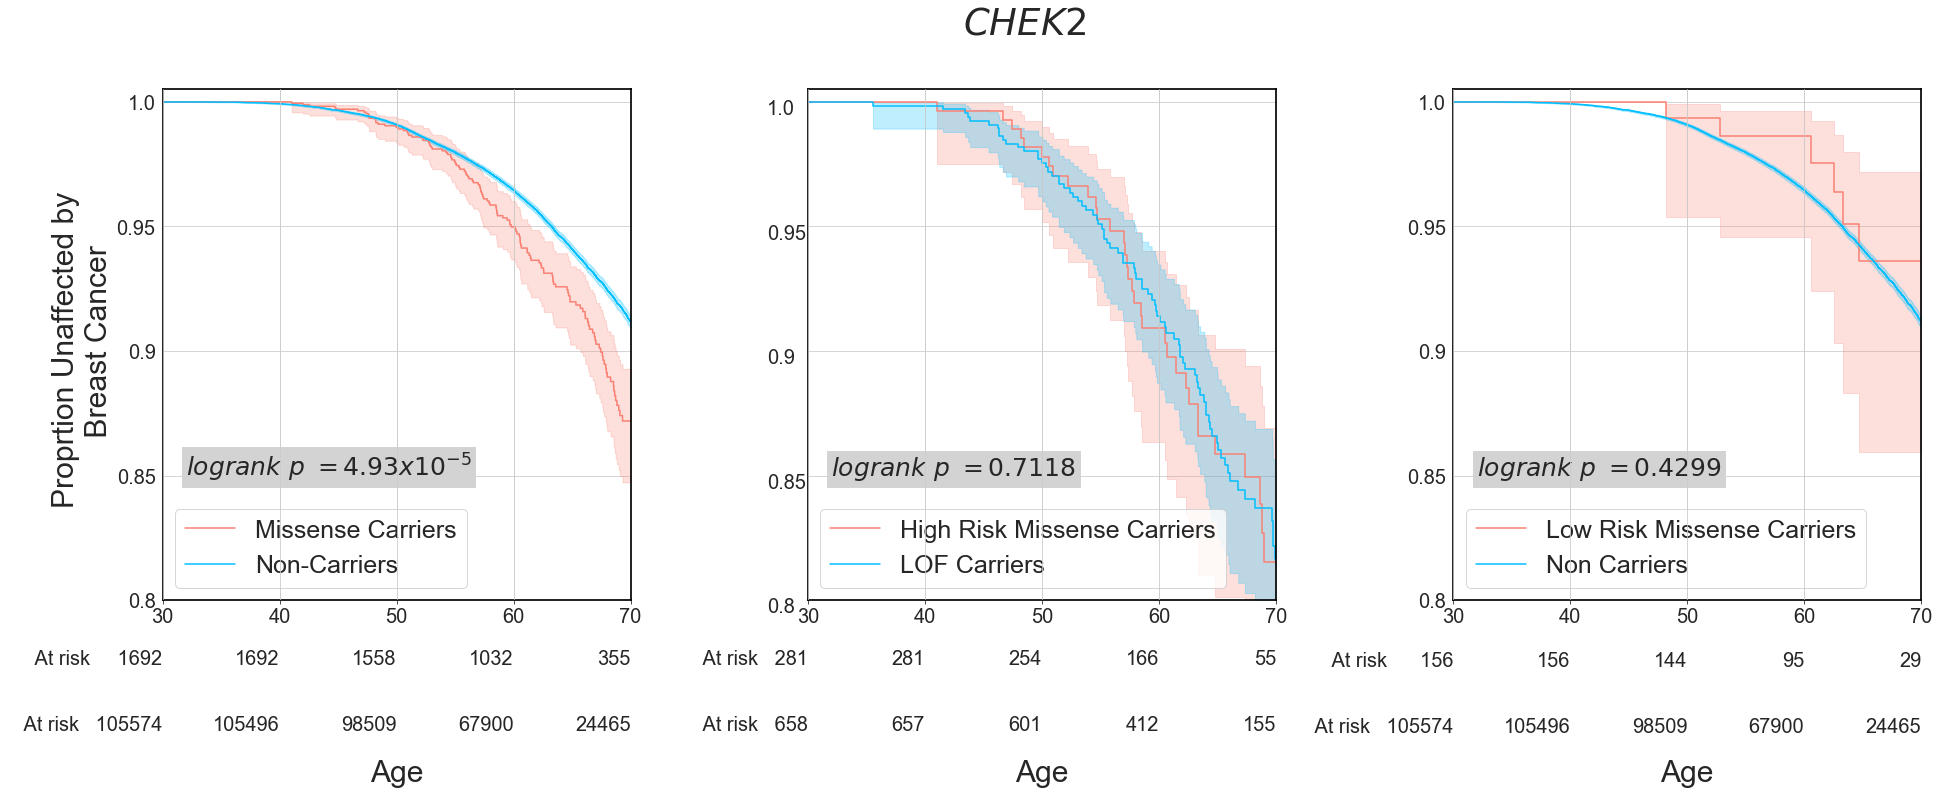

In [17]:
gene = "CHEK2"

key_of_interest = "CHEK2_11_0.15"
best_val = logrank_df.loc[logrank_df["key"] == key_of_interest].iloc[0]
high_regions = list(map(lambda x : int(x), best_val["high_regions"].split("|")))
low_regions = list(map(lambda x : int(x), best_val["low_regions"].split("|")))
breakpoints = list(map(lambda x : int(float(x)), best_val["breakpoints"].split("|")))
breakpoints[-1] = gene_to_end_position[gene]
gene_region_df = get_annotated_hr_lr_regions(
    gene, 
    breakpoints, 
    high_regions, 
    low_regions, 
    gene_to_df_loc = my_path + "gene_to_df_delet_removed_092922.pickle"
)


s1 = gene_region_df.loc[gene_region_df["high_region_carrier"] == 1]
s2 = gene_region_df.loc[gene_region_df["low_region_carrier"] == 1]

rr = risk_ratio(s1, s2, return_confidence = True, t = 65)
print(rr)


E1 = s1["breastcancer"].values
T1 = s1["breastcancer_age"].values

E2 = s2["breastcancer"].values
T2 = s2["breastcancer_age"].values


gene_df = gene_to_df["CHEK2"]
delet_carriers= gene_df.loc[
    gene_df["Deleterious"] == 1
]

E3 = delet_carriers["breastcancer"].values
T3 = delet_carriers["breastcancer_age"].values

non_carriers = gene_region_df.loc[
    gene_region_df["Missense"] == 0
]

E4 = non_carriers["breastcancer"].values
T4 = non_carriers["breastcancer_age"].values

all_missense_carriers = gene_region_df.loc[gene_region_df["Missense"] == 1]
E5 = all_missense_carriers["breastcancer"].values
T5 = all_missense_carriers["breastcancer_age"].values


fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (27,10))

ax1.set_xlabel("\n\nAge\n\n", fontsize = 30)
get_km_curve_ax(
    ax1, 
    T5,
    T4,
    E5,
    E4,
    label_group_1 = "Missense Carriers",
    label_group_2 = "Non-Carriers",
    color_group_1 = "salmon",
    color_group_2 = "deepskyblue",
#     title = "$\it{" + gene + "}$",
    show_logrank = False,
    show_at_risk_counts = True,
    x_tick_plot = [30,40,50,60,70],
    at_risk_y_offset = -10,
    legend_fontsize = 25, 
    use_xlabel = False,
    use_ylabel = False 
    
)
ax1.set_ylim(bottom = 0.8, top = 1.005)
ax1.set_yticks([0.8,0.85,0.9,0.95,1.0])
ax1.set_yticklabels([0.8,0.85,0.9,0.95,1.0], fontsize = 20)
ax1.set_xticks([30,40,50,60,70])
ax1.set_xticklabels([30,40,50,60,70], fontsize = 20)
ax1.set_ylabel("Proprtion Unaffected by \n Breast Cancer", fontsize = 30)
ax1.set_xlabel("\n\n\n\nAge", fontsize = 30)
logrank_text = get_logrank_text(T5,T4,E5,E4)
ax1.text(32,0.85, logrank_text, bbox={"color": "lightgray"}, fontsize = 25)

# ax1.set_xlim(left = 30, right = 70)

rr = risk_ratio(all_missense_carriers, non_carriers, return_confidence = True, t = 65)
print(rr, logrank_text)

get_km_curve_ax(
    ax2, 
    T1,
    T3,
    E1,
    E3,
    label_group_1 = "High Risk Missense Carriers",
    label_group_2 = "LOF Carriers",
    color_group_1 = "salmon",
    color_group_2 = "deepskyblue",
    show_logrank = False,
    show_at_risk_counts = True,
    x_tick_plot = [30,40,50,60,70],
    at_risk_y_offset = -10,
    legend_fontsize = 25, 
    use_xlabel = False,
    use_ylabel = False 
)


ax2.set_ylim(bottom = 0.8, top = 1.005)
ax2.set_yticks([0.8,0.85,0.9,0.95,1.0])
ax2.set_yticklabels([0.8,0.85,0.9,0.95,1.0], fontsize = 20)
for i in [0.8,0.85,0.9,0.95,1.0]:
    ax2.text(26.5, i-0.005, str(i), fontsize = 20)
ax2.set_xticks([30,40,50,60,70])
ax2.set_xticklabels([30,40,50,60,70], fontsize = 20)
ax2.set_ylabel("Proportion Unaffected by \n Breast Cancer", fontsize = 30)
ax2.set_xlabel("\n\n\n\nAge", fontsize = 30)

logrank_text = get_logrank_text( T1,T3,E1,E3,)
ax2.text(32,0.85, logrank_text, bbox={"color": "lightgray"}, fontsize = 25)


rr = risk_ratio(delet_carriers, s1, return_confidence = True, t = 65)
print(rr, logrank_text)

get_km_curve_ax(
    ax3, 
    T2,
    T4,
    E2,
    E4,
    label_group_1 = "Low Risk Missense Carriers",
    label_group_2 = "Non Carriers",
    color_group_1 = "salmon",
    color_group_2 = "deepskyblue",
#     title = "$\it{" + gene + "}$",
    show_logrank = False,
    show_at_risk_counts = True,
    x_tick_plot = [30,40,50,60,70],
    at_risk_y_offset = -10,
    legend_fontsize = 25, 
    use_xlabel = False,
    use_ylabel = False 
)

ax3.set_ylim(bottom = 0.8, top = 1.005)
ax3.set_yticks([0.8,0.85,0.9,0.95,1.0])
ax3.set_yticklabels([0.8,0.85,0.9,0.95,1.0], fontsize = 20)
# for i in [0.8,0.85,0.9,0.95,1.0]:
#     ax3.text(26.5, i-0.005, str(i), fontsize = 20)
ax3.set_xticks([30,40,50,60,70])
ax3.set_xticklabels([30,40,50,60,70], fontsize = 20)
ax3.set_xlabel("\n\n\n\nAge", fontsize = 30)

logrank_text = get_logrank_text( T2,T4,E2,E4,)
ax3.text(32,0.85, logrank_text, bbox={"color": "lightgray"}, fontsize = 25)

rr = risk_ratio(s2, non_carriers, return_confidence = True, t = 65)
print(rr, logrank_text)


fig.suptitle("           $\it{CHEK2}$", fontsize = 37, y =1.10)

[x.set_linewidth(1.7) for x in ax1.spines.values()]
[x.set_edgecolor('black') for x in ax1.spines.values()]
[x.set_linewidth(1.7) for x in ax2.spines.values()]
[x.set_edgecolor('black') for x in ax2.spines.values()]
[x.set_linewidth(1.7) for x in ax3.spines.values()]
[x.set_edgecolor('black') for x in ax3.spines.values()]
# fig.savefig("./high_res_figures/092922_Fig3B_CHEK2.png", bbox_inches = "tight")

(1.58, 1.27, 1.9, 811, 693, [[100, 711], [54, 639]])
(1.17, 1.06, 1.28, 3058, 49968, [[313, 2745], [4374, 45594]])
(1.57, 1.29, 1.85, 352, 811, [[68, 284], [100, 711]])
(0.89, 0.63, 1.15, 693, 49968, [[54, 639], [4374, 45594]]) $logrank \ p \ = 0.3049$


[None, None, None, None]

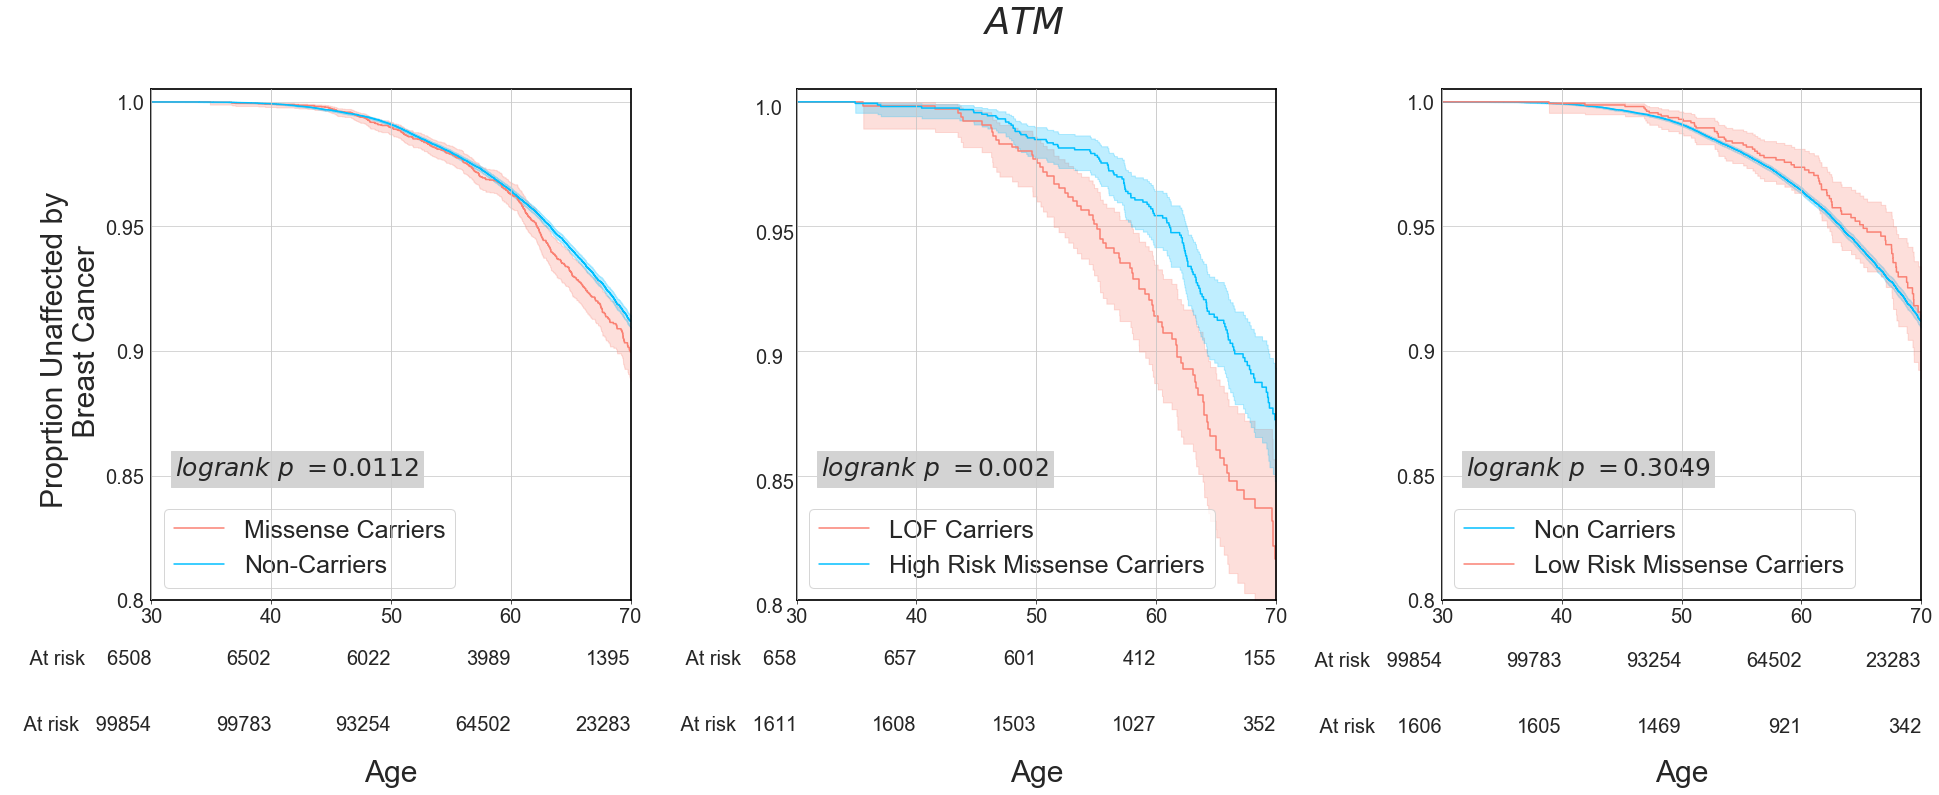

In [18]:
gene = "ATM"

key_of_interest = "ATM_15_0.15"
best_val = logrank_df.loc[logrank_df["key"] == key_of_interest].iloc[0]
high_regions = list(map(lambda x : int(x), best_val["high_regions"].split("|")))
low_regions = list(map(lambda x : int(x), best_val["low_regions"].split("|")))
breakpoints = list(map(lambda x : int(float(x)), best_val["breakpoints"].split("|")))
breakpoints[-1] = gene_to_end_position[gene]
gene_region_df = get_annotated_hr_lr_regions(
    gene, 
    breakpoints, 
    high_regions, 
    low_regions, 
    gene_to_df_loc = my_path + "gene_to_df_delet_removed_092922.pickle"
)


s1 = gene_region_df.loc[gene_region_df["high_region_carrier"] == 1]
s2 = gene_region_df.loc[gene_region_df["low_region_carrier"] == 1]

rr = risk_ratio(s1, s2, return_confidence = True, t = 65)
print(rr)


E1 = s1["breastcancer"].values
T1 = s1["breastcancer_age"].values

E2 = s2["breastcancer"].values
T2 = s2["breastcancer_age"].values


gene_df = gene_to_df["CHEK2"]
delet_carriers= gene_df.loc[
    gene_df["Deleterious"] == 1
]

E3 = delet_carriers["breastcancer"].values
T3 = delet_carriers["breastcancer_age"].values

non_carriers = gene_region_df.loc[
    gene_region_df["Missense"] == 0
]

E4 = non_carriers["breastcancer"].values
T4 = non_carriers["breastcancer_age"].values

all_missense_carriers = gene_region_df.loc[gene_region_df["Missense"] == 1]
E5 = all_missense_carriers["breastcancer"].values
T5 = all_missense_carriers["breastcancer_age"].values


fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (27,10))
ax1.set_xlabel("\n\nAge\n\n", fontsize = 30)
get_km_curve_ax(
    ax1, 
    T5,
    T4,
    E5,
    E4,
    label_group_1 = "Missense Carriers",
    label_group_2 = "Non-Carriers",
    color_group_1 = "salmon",
    color_group_2 = "deepskyblue",
#     title = "$\it{" + gene + "}$",
    show_logrank = False,
    show_at_risk_counts = True,
    x_tick_plot = [30,40,50,60,70],
    at_risk_y_offset = -10,
    legend_fontsize = 25, 
    use_xlabel = False,
    use_ylabel = False 
    
)
ax1.set_ylim(bottom = 0.8, top = 1.005)
ax1.set_yticks([0.8,0.85,0.9,0.95,1.0])
ax1.set_yticklabels([0.8,0.85,0.9,0.95,1.0], fontsize = 20)
ax1.set_xticks([30,40,50,60,70])
ax1.set_xticklabels([30,40,50,60,70], fontsize = 20)
ax1.set_ylabel("Proprtion Unaffected by \n Breast Cancer", fontsize = 30)
ax1.set_xlabel("\n\n\n\nAge", fontsize = 30)
logrank_text = get_logrank_text(T5,T4,E5,E4)
ax1.text(32,0.85, logrank_text, bbox={"color": "lightgray"}, fontsize = 25)

# ax1.set_xlim(left = 30, right = 70)

rr = risk_ratio(all_missense_carriers, non_carriers, return_confidence = True, t = 65)
print(rr)

get_km_curve_ax(
    ax2, 
    T3,
    T1,
    E3,
    E1,
    label_group_2 = "High Risk Missense Carriers",
    label_group_1 = "LOF Carriers",
    color_group_2 = "deepskyblue",
    color_group_1 = "salmon",
    show_logrank = False,
    show_at_risk_counts = True,
    x_tick_plot = [30,40,50,60,70],
    at_risk_y_offset = -10,
    legend_fontsize = 25, 
    use_xlabel = False,
    use_ylabel = False 
)


ax2.set_ylim(bottom = 0.8, top = 1.005)
ax2.set_yticks([0.8,0.85,0.9,0.95,1.0])
ax2.set_yticklabels([0.8,0.85,0.9,0.95,1.0], fontsize = 20)
for i in [0.8,0.85,0.9,0.95,1.0]:
    ax2.text(26.5, i-0.005, str(i), fontsize = 20)
ax2.set_xticks([30,40,50,60,70])
ax2.set_xticklabels([30,40,50,60,70], fontsize = 20)
ax2.set_ylabel("Proportion Unaffected by \n Breast Cancer", fontsize = 30)
ax2.set_xlabel("\n\n\n\nAge", fontsize = 30)

logrank_text = get_logrank_text( T1,T3,E1,E3,)
ax2.text(32,0.85, logrank_text, bbox={"color": "lightgray"}, fontsize = 25)


rr = risk_ratio(delet_carriers, s1, return_confidence = True, t = 65)
print(rr)

get_km_curve_ax(
    ax3, 
    T4,
    T2,
    E4,
    E2,
    label_group_2 = "Low Risk Missense Carriers",
    label_group_1 = "Non Carriers",
    color_group_1 = "deepskyblue",
    color_group_2 = "salmon",
#     title = "$\it{" + gene + "}$",
    show_logrank = False,
    show_at_risk_counts = True,
    x_tick_plot = [30,40,50,60,70],
    at_risk_y_offset = -10,
    legend_fontsize = 25, 
    use_xlabel = False,
    use_ylabel = False 
)

ax3.set_ylim(bottom = 0.8, top = 1.005)
ax3.set_yticks([0.8,0.85,0.9,0.95,1.0])
ax3.set_yticklabels([0.8,0.85,0.9,0.95,1.0], fontsize = 20)
# for i in [0.8,0.85,0.9,0.95,1.0]:
#     ax3.text(26.5, i-0.005, str(i), fontsize = 20)
ax3.set_xticks([30,40,50,60,70])
ax3.set_xticklabels([30,40,50,60,70], fontsize = 20)
ax3.set_xlabel("\n\n\n\nAge", fontsize = 30)

logrank_text = get_logrank_text( T2,T4,E2,E4,)
ax3.text(32,0.85, logrank_text, bbox={"color": "lightgray"}, fontsize = 25)

rr = risk_ratio(s2, non_carriers, return_confidence = True, t = 65)
print(rr, logrank_text)


fig.suptitle("           $\it{ATM}$", fontsize = 37, y =1.10)

[x.set_linewidth(1.7) for x in ax1.spines.values()]
[x.set_edgecolor('black') for x in ax1.spines.values()]
[x.set_linewidth(1.7) for x in ax2.spines.values()]
[x.set_edgecolor('black') for x in ax2.spines.values()]
[x.set_linewidth(1.7) for x in ax3.spines.values()]
[x.set_edgecolor('black') for x in ax3.spines.values()]

# fig.savefig("./high_res_figures/092922_Fig3B_ATM.png", bbox_inches = "tight")

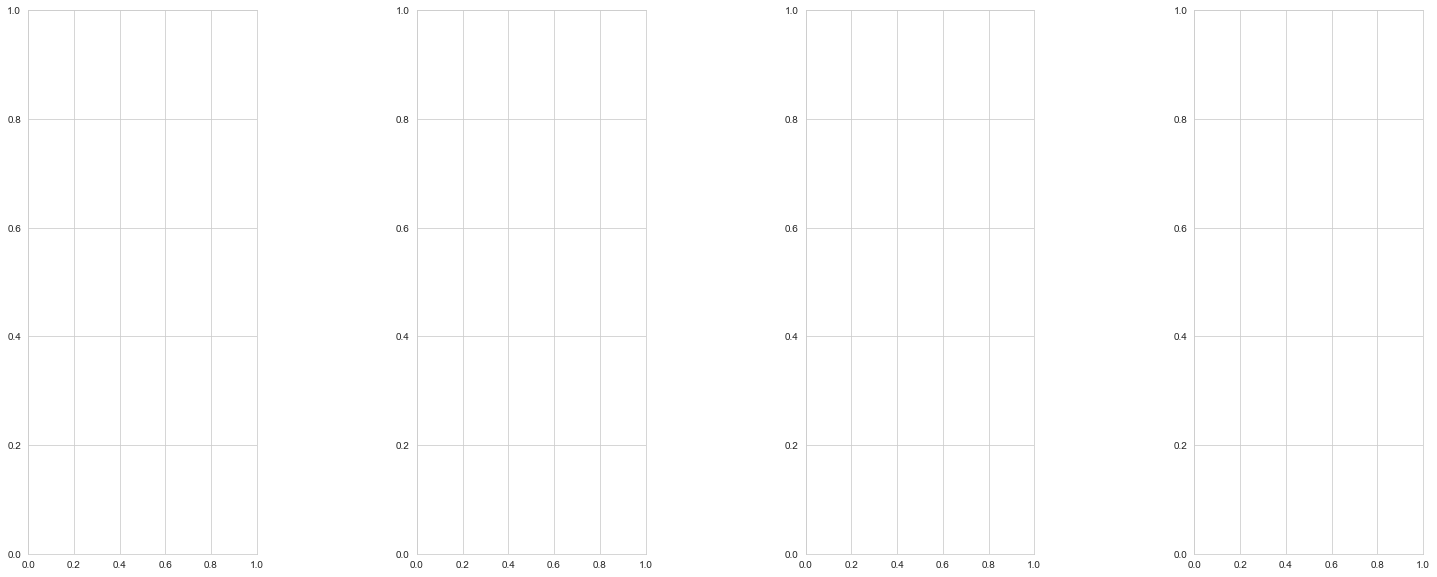

In [19]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize = (25,10))
fig.subplots_adjust(wspace = 0.7)
all_func_data = []

In [20]:
key = "BRCA1_15_0.15"
ax = ax1
optimal = logrank_df.loc[logrank_df["key"] == key].iloc[0]

df = pd.read_excel("../../data/functional_data/BRCA1_41586_2018_461_MOESM3_ESM.xlsx", skiprows = 2)
df = df.loc[
    (~df["transcript_position"].str.contains("+", regex = False)) &
    (~df["transcript_position"].str.contains("-", regex = False)) &
    (df["consequence"] == "Missense")
]

df["coding_position"] = df["transcript_position"].apply(lambda x : int(x))
optimal = logrank_df.loc[logrank_df["key"] == key].iloc[0]
optimal_breaks = list(map(lambda x : int(float(x)), optimal["breakpoints"].split("|")))
optimal_high = list(map(lambda x : int(x), optimal["high_regions"].split("|")))
optimal_low = list(map(lambda x : int(x), optimal["low_regions"].split("|")))
reg = []
for index, row in df.iterrows():
    p = row["coding_position"]
    region = place_position(optimal_breaks, p) + 1
    reg.append(region)

    
df["region"] = reg
col = "function.score.mean"

c_pos_mean = {}
for c in set(df["coding_position"].values):
    subset = df.loc[df["coding_position"] == c]
    c_pos_mean[c] = np.mean(subset[col].values)


df["c_pos_mean"] = df["coding_position"].apply(lambda x : c_pos_mean[x])
df = df.drop_duplicates(subset = "coding_position")

df["in HR"] = df["region"].apply(lambda x : x in optimal_high)
df["in LR"] = df["region"].apply(lambda x : x in optimal_low)
hr_df = df.loc[df["in HR"]]
lr_df = df.loc[df["in LR"]]

if len(hr_df.loc[~hr_df[col].isna()]) > 0 and len(lr_df.loc[~lr_df[col].isna()]) > 0:
    a = hr_df.loc[~hr_df[col].isna()][col].values
    b = lr_df.loc[~lr_df[col].isna()][col].values
    
high_vals = hr_df.loc[~hr_df[col].isna()][col].values
low_vals = lr_df.loc[~lr_df[col].isna()][col].values

high_regions = optimal["high_regions"].split("|")
low_regions = optimal["low_regions"].split("|")

sns.stripplot(
    data=[a, b], 
    ax = ax, 
    alpha = 0.3, 
    zorder = 0,
    palette = {0: "salmon", 1:"powderblue"}
)
sns.boxplot(
    data=[a, b], 
    ax = ax, 
    showfliers = False, 
    zorder = 100,
    boxprops=dict(
        facecolor=(1,0,0,0), 
        edgecolor=(0,0,0,1), 
        linestyle='-'
    ),
    medianprops = dict(
        color = "black" 
    ),
    width = 0.4
)


ax.set_ylabel("Functional Score \n", fontsize = 17)
ax.text(-0.16, 0.355, "Findlay et al., $\it{Nature}$ (2018)", rotation = 90, fontsize = 13, transform=ax.transAxes)
p_string=format_p_string(scipy.stats.ks_2samp(a,b).pvalue)
print(p_string)
ax.text(0.23, -0.2, "______________", transform=ax.transAxes, fontsize = 15)
ax.text(0.22, -0.195, "|", transform=ax.transAxes, fontsize = 20)
ax.text(0.725, -0.195, "|", transform=ax.transAxes, fontsize = 20)
ax.text(0.28, -0.25, "$p = " + p_string.replace("$", "")  + "$",  transform=ax.transAxes, fontsize = 15)


ax.set_title("$\it{BRCA1}$ \n", fontsize = 20)
ax.set_xticklabels(["\nRegions \n" + ", ".join(high_regions) ,"\nRegions \n" + ", ".join(low_regions)], fontsize = 15)

$0.0065$


[Text(0.0, 0, '\nRegions \n1, 2, 3, 15'),
 Text(0.2, 0, '\nRegions \n6, 8, 11, 12, 13')]

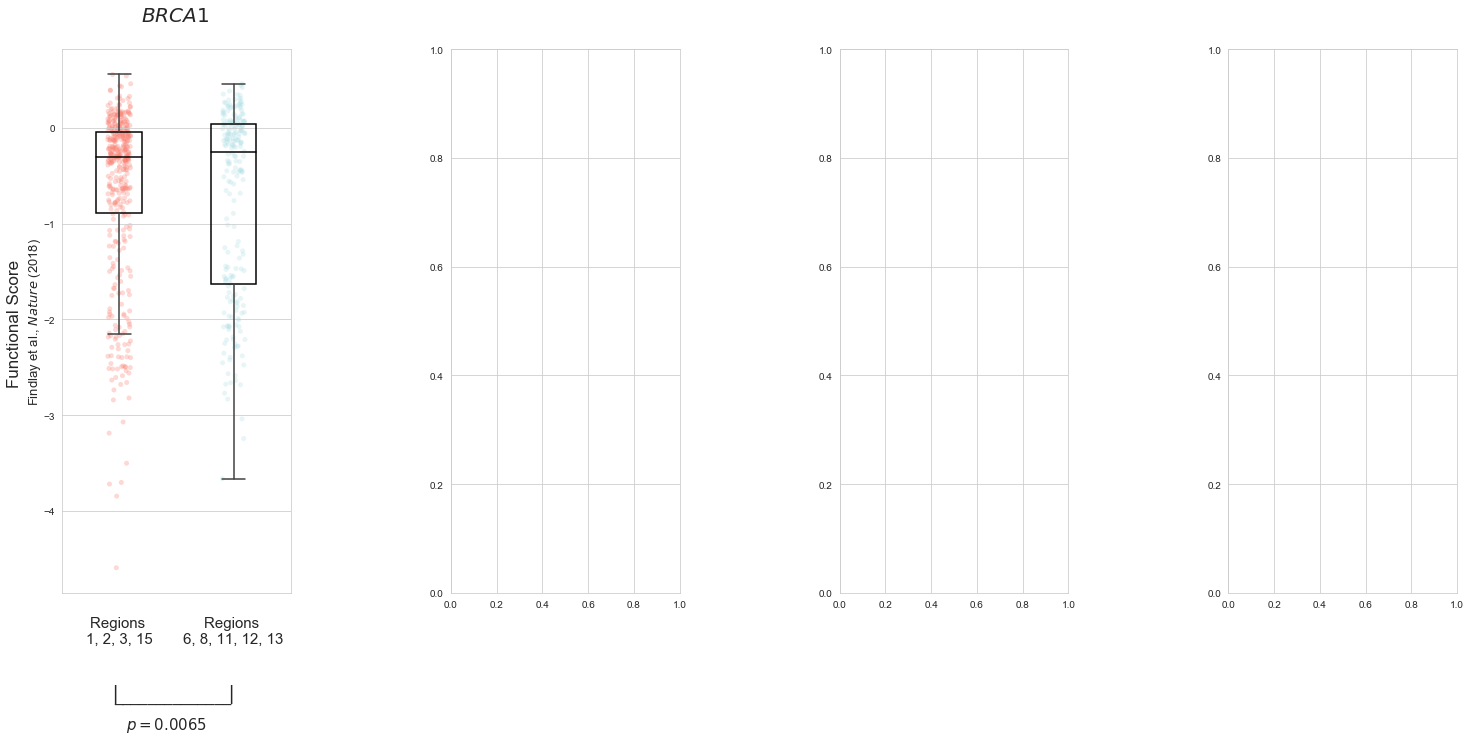

In [21]:
fig

In [22]:
key = "BRCA2_15_0.15"
ax = ax2
df_a = pd.read_excel('/Users/jdf36/Desktop/bwh/cancer_regions/data/functional_data/Ikegami_BRCA2_41467_2020_16141_MOESM11_ESM.xlsx', index_col = 0, sheet_name = "Figure_3d")
dict_a = {
    "Variant" : df_a.loc["Variant"].values,
    "Eta_average" : df_a.loc["Eta_average"].values
}

df_a = pd.DataFrame.from_dict(dict_a, orient = "index")
df_a = df_a.transpose()
pos = []
ref = []
alt = []
for v in df_a["Variant"].values:
    if v in ["Wild-type","Empty-vector"]:
        pos.append(None)
        ref.append(None)
        alt.append(None)
    else:
        ref.append(v[0])
        alt.append(v[-1])
        pos.append(int(v[1:-1]))

df_a["ref"] = ref
df_a["alt"] = alt
df_a["pos"] = pos
df_a = df_a.dropna()
df_a["pos"] = df_a["pos"].apply(lambda x : int(x))
df_a["coding_pos"] = df_a["pos"].apply(lambda x : int(x * 3))

c_pos_mean = {}
for c in set(df_a["coding_pos"].values):
    subset = df_a.loc[df_a["coding_pos"] == c]
    c_pos_mean[c] = np.mean(subset["Eta_average"].values)

df_a["c_pos_mean"] = df_a["coding_pos"].apply(lambda x : c_pos_mean[x])
df_a = df_a.drop_duplicates(subset = "coding_pos")

corr_dicts = {}
results = []

df = copy.deepcopy(df_a)
optimal = logrank_df.loc[logrank_df["key"] == key].iloc[0]
optimal_breaks = list(map(lambda x : int(float(x)), optimal["breakpoints"].split("|")))
optimal_high = list(map(lambda x : int(x), optimal["high_regions"].split("|")))
optimal_low = list(map(lambda x : int(x), optimal["low_regions"].split("|")))

df = df.drop_duplicates(subset = "coding_pos")
reg = []
for index, row in df.iterrows():
    p = row["coding_pos"]
    region = place_position(optimal_breaks, p) + 1
    reg.append(region)

df["region"] = reg
df["in HR"] = df["region"].apply(lambda x : x in optimal_high)
df["in LR"] = df["region"].apply(lambda x : x in optimal_low)
hr_df = df.loc[df["in HR"]]
lr_df = df.loc[df["in LR"]]
col = "Eta_average"
to_return = {
    "functional pval" : None,
    "HR covered" : len(hr_df.loc[~hr_df[col].isna()]) ,
    "LR covered" : len(lr_df.loc[~lr_df[col].isna()]),
    "correlation" : None,
    "correlation p" : None,
    "x_functional" : None,
    "x_regression" : None
}

if len(hr_df.loc[~hr_df[col].isna()]) > 0 and len(lr_df.loc[~lr_df[col].isna()]) > 0:
    a = hr_df.loc[~hr_df[col].isna()][col].values
    b = lr_df.loc[~lr_df[col].isna()][col].values

high_regions = optimal["high_regions"].split("|")
low_regions = optimal["low_regions"].split("|")
sns.stripplot(
    data=[a, b], 
    ax = ax, 
    alpha = 0.3, 
    zorder = 0,
    palette = {0: "salmon", 1:"powderblue"}
#     color = ["salmon", "powderblue"]
)
sns.boxplot(
    data=[a, b], 
    ax = ax, 
    showfliers = False, 
    zorder = 100,
    boxprops=dict(
        facecolor=(1,0,0,0), 
        edgecolor=(0,0,0,1), 
        linestyle='-'
    ),
    medianprops = dict(
        color = "black" 
    ),
    width = 0.4
    
)


ax.set_title("$\it{BRCA2}$ \n", fontsize = 20)
ax.set_ylabel("Functional Score \n", fontsize = 17)
ax.text(-0.2, 0.31, "Ikegami et al., $\it{Nat. \ Commun.}$ (2020)", rotation = 90, fontsize = 13, transform=ax.transAxes)
p_string=format_p_string(scipy.stats.ks_2samp(a,b).pvalue)
ax.text(0.23, -0.2, "______________", transform=ax.transAxes, fontsize = 15)
ax.text(0.22, -0.195, "|", transform=ax.transAxes, fontsize = 20)
ax.text(0.725, -0.195, "|", transform=ax.transAxes, fontsize = 20)
ax.text(0.31, -0.25, "$p = " + p_string.replace("$", "")  + "$",  transform=ax.transAxes, fontsize = 15)
ax.set_xticklabels(["\nRegions \n" + ", ".join(high_regions) ,"\nRegions \n" + ", ".join(low_regions)], fontsize = 15)

[Text(0.0, 0, '\nRegions \n4, 6, 10, 12, 14, 15'),
 Text(0.2, 0, '\nRegions \n2, 7')]

In [23]:
key = "TP53_15_0.15"
ax = ax4

df_a = pd.read_excel("/Users/jdf36/Desktop/bwh/cancer_regions/data/functional_data/TP53_Giacomelli_et_al.xlsx", skiprows = 1)
df = copy.deepcopy(df_a)
optimal = logrank_df.loc[logrank_df["key"] == key].iloc[0]
optimal_breaks = list(map(lambda x : int(float(x)), optimal["breakpoints"].split("|")))
optimal_high = list(map(lambda x : int(x), optimal["high_regions"].split("|")))
optimal_low = list(map(lambda x : int(x), optimal["low_regions"].split("|")))
df["coding_pos"] = df["Position"].apply(lambda x : x*3)
df = df.drop_duplicates(subset = "coding_pos")
reg = []
for index, row in df.iterrows():
    p = row["coding_pos"]
    region = place_position(optimal_breaks, p) + 1
    reg.append(region)

df["region"] = reg
df["in HR"] = df["region"].apply(lambda x : x in optimal_high)
df["in LR"] = df["region"].apply(lambda x : x in optimal_low)
hr_df = df.loc[df["in HR"]]
lr_df = df.loc[df["in LR"]]
col = "A549_p53NULL_Nutlin-3_Z-score"


to_return = {
    "functional pval" : None,
    "HR covered" : len(hr_df.loc[~hr_df[col].isna()]) ,
    "LR covered" : len(lr_df.loc[~lr_df[col].isna()]),
    "correlation" : None,
    "correlation p" : None
}

if len(hr_df.loc[~hr_df[col].isna()]) > 0 and len(lr_df.loc[~lr_df[col].isna()]) > 0:
    a = hr_df.loc[~hr_df[col].isna()][col].values
    b = lr_df.loc[~lr_df[col].isna()][col].values

high_regions = optimal["high_regions"].split("|")
low_regions = optimal["low_regions"].split("|")

sns.stripplot(
    data=[a, b], 
    ax = ax, 
    alpha = 0.3, 
    zorder = 0,
    palette = {0: "salmon", 1:"powderblue"}
#     color = ["salmon", "powderblue"]
)
sns.boxplot(
    data=[a, b], 
    ax = ax, 
    showfliers = False, 
    zorder = 100,
    boxprops=dict(
        facecolor=(1,0,0,0), 
        edgecolor=(0,0,0,1), 
        linestyle='-'
    ),
    medianprops = dict(
        color = "black" 
    ),
    width = 0.4
)

ax.set_title("$\it{TP53}$ \n", fontsize = 20)
ax.set_xticklabels([
    "\nRegions \n" + ", ".join(high_regions) ,
    "\nRegions \n" + ", ".join(low_regions[:5]) + "\n" + " ,".join(low_regions[5:])
    ], 
    fontsize = 15
)




ax.set_ylabel("Functional Score \n", fontsize = 17)
ax.text(-0.16, 0.33, "Giacomelli et al., $\it{Nat. \ Genet.}$ (2018)", rotation = 90, fontsize = 13, transform=ax.transAxes)

p_string=format_p_string(scipy.stats.ks_2samp(a,b).pvalue)
ax.text(0.23, -0.2, "______________", transform=ax.transAxes, fontsize = 15)
ax.text(0.22, -0.195, "|", transform=ax.transAxes, fontsize = 20)
ax.text(0.725, -0.195, "|", transform=ax.transAxes, fontsize = 20)
ax.text(0.28, -0.25, "$p = " + p_string.replace("$", "")  + "$",  transform=ax.transAxes, fontsize = 15)



Text(0.28, -0.25, '$p = 2.15x10^{-5}$')

In [24]:
key = "PALB2_5_0.15"

ax = ax3 
optimal = logrank_df.loc[logrank_df["key"] == key].iloc[0]
optimal_breaks = list(map(lambda x : int(float(x)), optimal["breakpoints"].split("|")))
optimal_high = list(map(lambda x : int(x), optimal["high_regions"].split("|")))
optimal_low = list(map(lambda x : int(x), optimal["low_regions"].split("|")))

df = pd.read_csv('/Users/jdf36/Desktop/bwh/cancer_regions/data/functional_data/PALB2_rodrigue_et_al.csv')
aa_pos = []
region = []
c_pos = []
for index, row in df.iterrows():
    pos = int(row["variant"][1:-1])
    c_pos.append(pos*3)
    reg = place_position(optimal_breaks, pos*3) + 1
    region.append(reg)

df["region"] = region
df["coding_position"] = c_pos
df = df.drop_duplicates(subset = "coding_position")



df["in HR"] = df["region"].apply(lambda x : x in optimal_high)
df["in LR"] = df["region"].apply(lambda x : x in optimal_low)

hr_df = df.loc[df["in HR"]]
lr_df = df.loc[df["in LR"]]
col_of_interest = "Relative % survival"
to_return = {
    "functional pval" : None,
    "HR covered" : len(hr_df.loc[~hr_df[col_of_interest].isna()]) ,
    "LR covered" : len(lr_df.loc[~lr_df[col_of_interest].isna()]),
    "correlation" : None,
    "correlation p" : None
}
if len(hr_df) > 0 and len(lr_df) > 0:
    # p = scipy.stats.ks_2samp(hr_df[col_of_interest].values, lr_df[col_of_interest].values).pvalue

    a = hr_df.loc[~hr_df[col_of_interest].isna()][col_of_interest].values
    b = lr_df.loc[~lr_df[col_of_interest].isna()][col_of_interest]


high_regions = optimal["high_regions"].split("|")
low_regions = optimal["low_regions"].split("|")

sns.stripplot(
    data=[a, b], 
    ax = ax, 
    alpha = 0.5, 
    zorder = 0,
    palette = {0: "salmon", 1:"powderblue"}
#     color = ["salmon", "powderblue"]
)
sns.boxplot(
    data=[a, b], 
    ax = ax, 
    showfliers = False, 
    zorder = 100,
    boxprops=dict(
        facecolor=(1,0,0,0), 
        edgecolor=(0,0,0,1), 
        linestyle='-'
    ),
    medianprops = dict(
        color = "black" 
    ),
    width = 0.4
    
)

ax.set_title("$\it{TP53}$ \n", fontsize = 20)
ax.set_xticklabels([
    "\nRegions \n" + ", ".join(high_regions) ,
    "\nRegions \n" + ", ".join(low_regions[:5]) + "\n" + " ,".join(low_regions[5:])
    ], 
    fontsize = 15
)

    
ax.set_title("$\it{PALB2}^{\dagger}$\n", fontsize = 20)
ax.set_ylabel("Functional Score \n", fontsize = 17)
ax.text(-0.16, 0.30, "Rodrigue et al., $\it{Nucleic\ Acids\ Res.}$ (2019)", rotation = 90, fontsize = 13, transform=ax.transAxes)

p_string=format_p_string(scipy.stats.ks_2samp(a,b).pvalue)
ax.text(0.23, -0.2, "______________", transform=ax.transAxes, fontsize = 15)
ax.text(0.22, -0.195, "|", transform=ax.transAxes, fontsize = 20)
ax.text(0.725, -0.195, "|", transform=ax.transAxes, fontsize = 20)
ax.text(0.31, -0.25, "$p = " + p_string.replace("$", "")  + "$",  transform=ax.transAxes, fontsize = 15)

Text(0.31, -0.25, '$p = 0.0335$')

In [25]:
# fig.savefig("./high_res_figures/092922_Fig4A.png", bbox_inches = "tight")

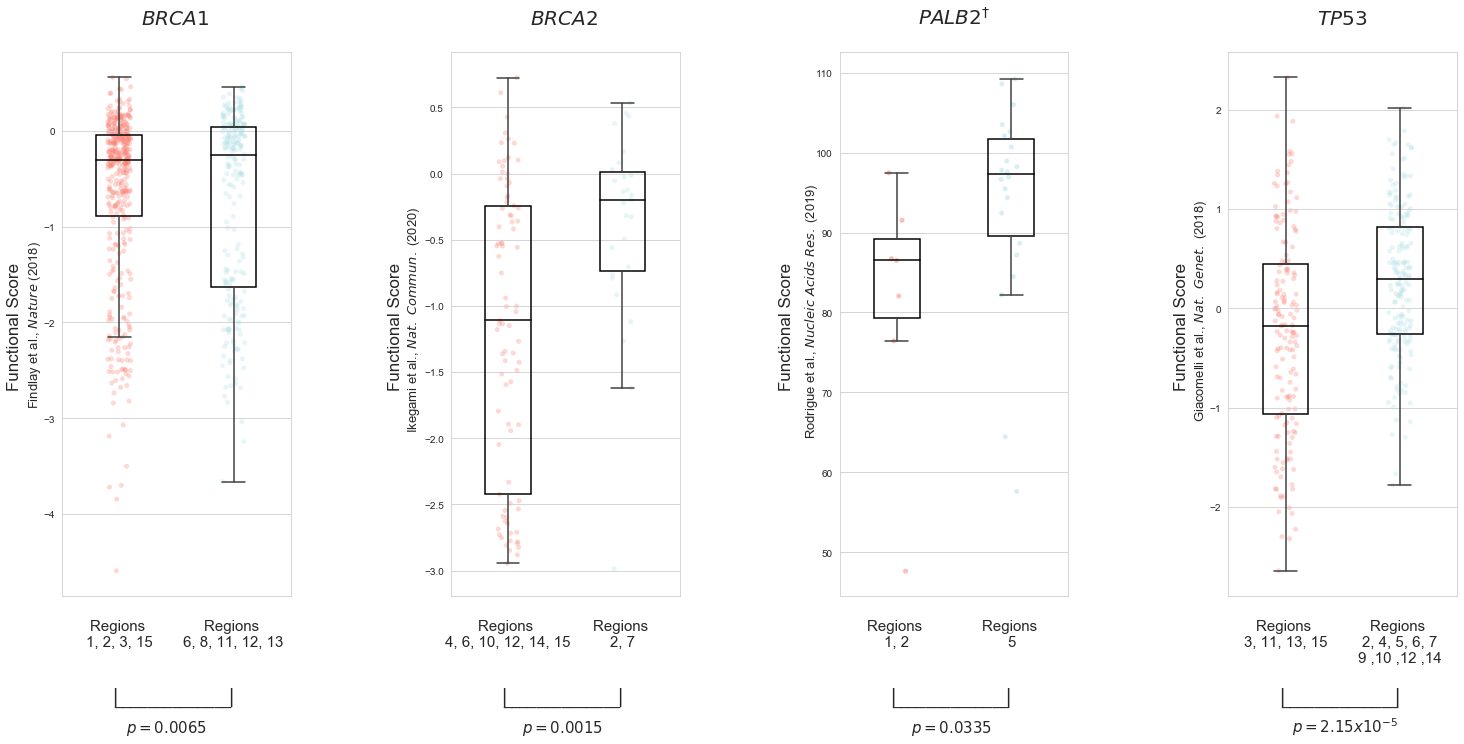

In [26]:
fig

In [27]:
BRCA1_pfam = get_annotated_pfam_profiles("BRCA1", use_preload = False, df = gene_to_df["BRCA1"])

In [28]:
genes_for_diagram = ["ATM", "BRCA1", "BRCA2", "CHEK2", "MSH6", "PALB2", "TP53"]
for g in genes_for_diagram:
    try:
        gene_df_pfam = get_annotated_pfam_profiles(g, use_preload = False, df = gene_to_df[g])
        pfam_carriers = gene_df_pfam.loc[
            (gene_df_pfam["any domain"] == 1) &
            (gene_df_pfam["to_drop"] == 0)
        ]

        non_pfam_carriers = gene_df_pfam.loc[
            (gene_df_pfam["any domain"] == 0) &
            (gene_df_pfam["Missense"] == 1)&
            (gene_df_pfam["to_drop"] == 0)
        ]

        non_carriers = gene_df_pfam.loc[
            (gene_df_pfam["Deleterious"] == 0) &
            (gene_df_pfam["Missense"] == 0)
        ]
        
        rr1 = risk_ratio(pfam_carriers, non_pfam_carriers, return_confidence = True, t = 65)
        
        
        
        logrank1 = get_logrank_text( 
             pfam_carriers["breastcancer_age"].values, 
             non_pfam_carriers["breastcancer_age"].values,
             pfam_carriers["breastcancer"].values,
             non_pfam_carriers["breastcancer"].values
         )
        print(g,rr1,logrank1)
    except:
        print("error w ", g)




ATM (0.87, 0.58, 1.16, 552, 2522, [[50, 502], [263, 2259]]) $logrank \ p \ = 0.9731$
BRCA1 (0.92, 0.47, 1.36, 263, 1299, [[21, 242], [113, 1186]]) $logrank \ p \ = 0.4781$
BRCA2 (1.0, 0.73, 1.28, 661, 3021, [[58, 603], [264, 2757]]) $logrank \ p \ = 0.1434$
error w  CHEK2
MSH6 (1.36, 1.01, 1.72, 1047, 681, [[88, 959], [42, 639]]) $logrank \ p \ = 0.2362$
PALB2 (0.84, 0.45, 1.22, 402, 653, [[35, 367], [68, 585]]) $logrank \ p \ = 0.2648$
TP53 (0.85, 0.08, 1.62, 153, 93, [[14, 139], [10, 83]]) $logrank \ p \ = 0.8829$


In [29]:
scipy.stats.chi2_contingency([[88, 959 - 88], [42, 639 - 42]])

(3.138338489550209,
 0.07647167308582088,
 1,
 array([[ 78.01627034, 880.98372966],
        [ 51.98372966, 587.01627034]]))

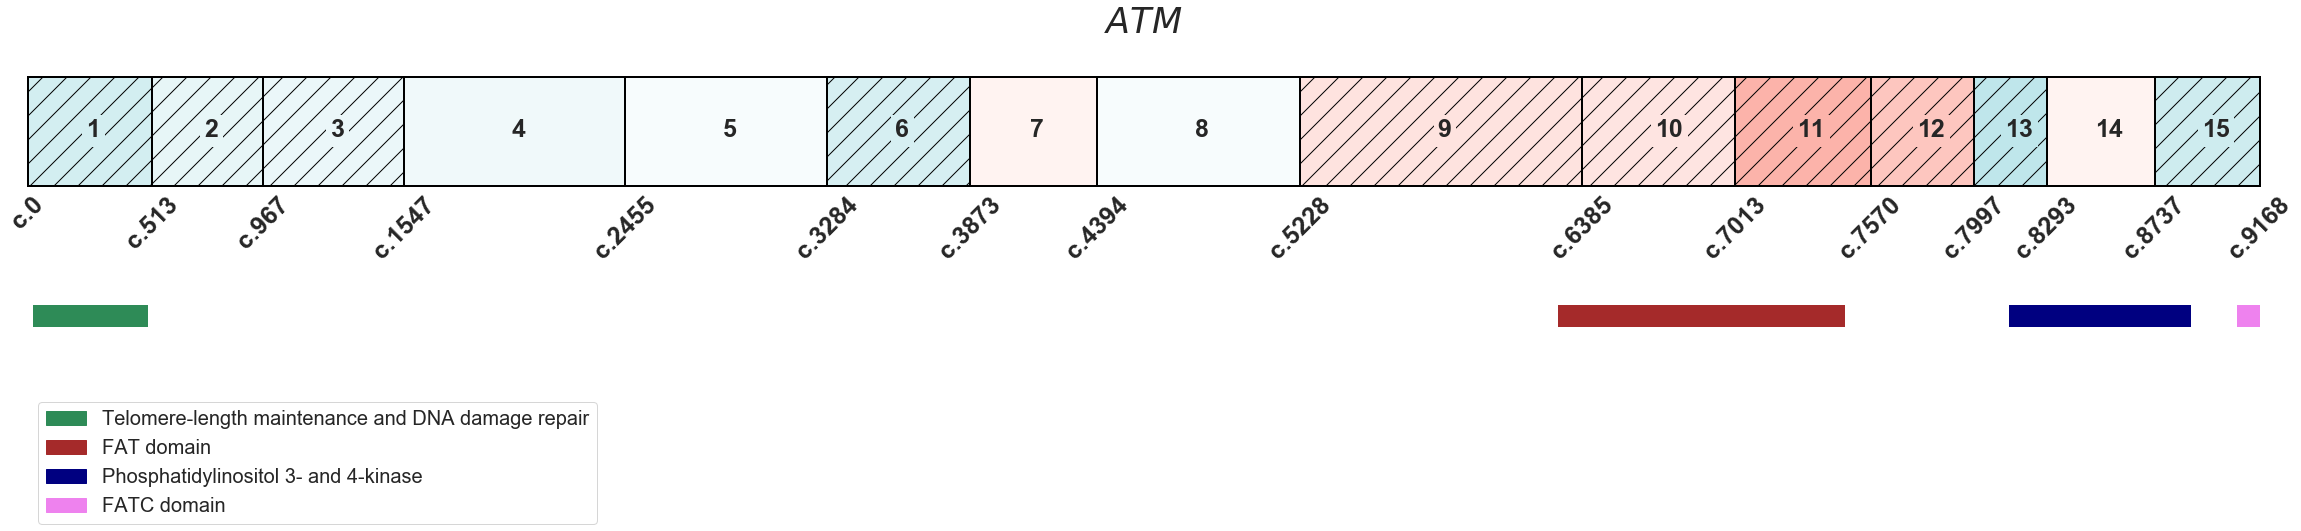

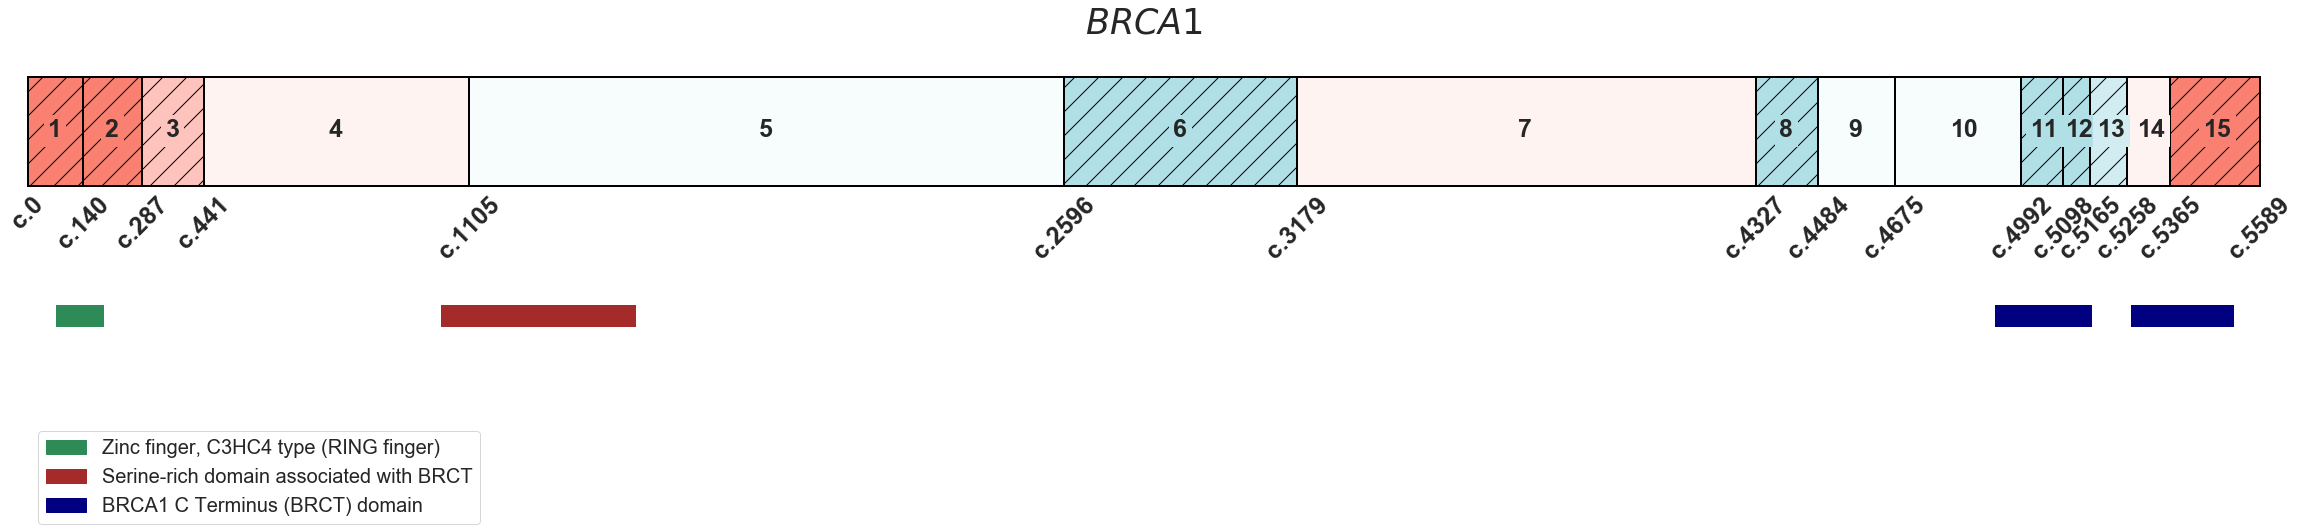

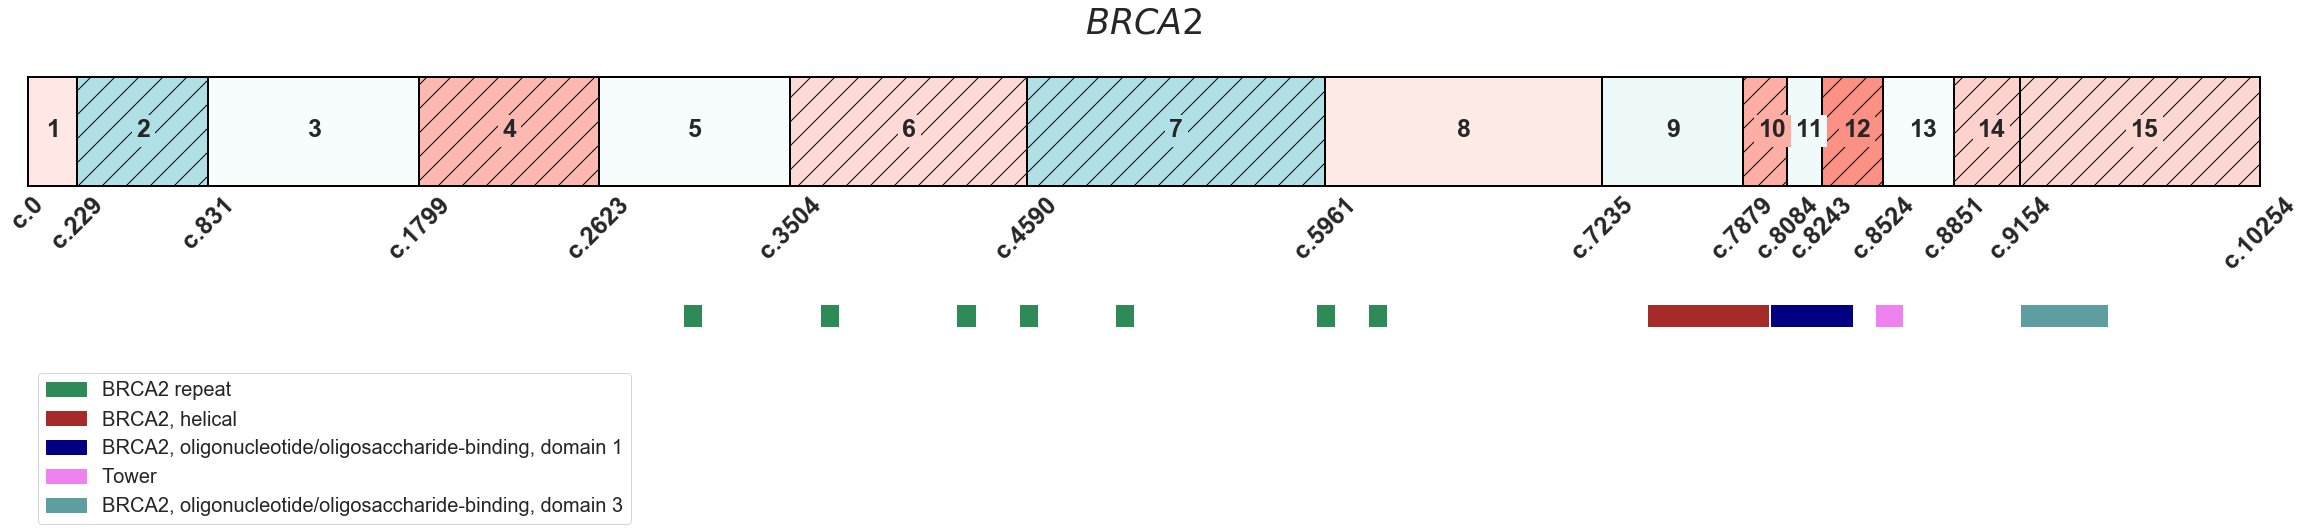

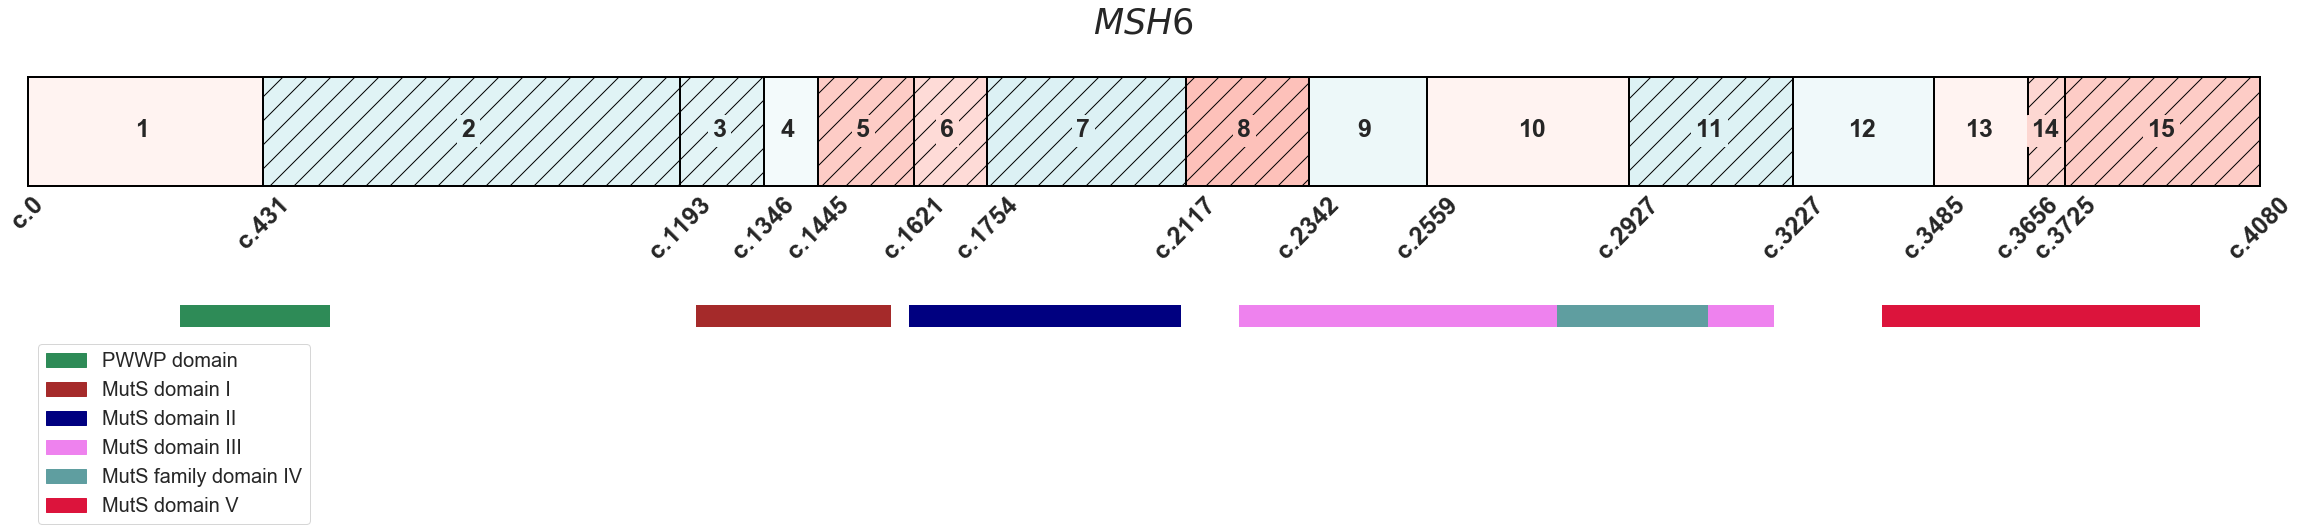

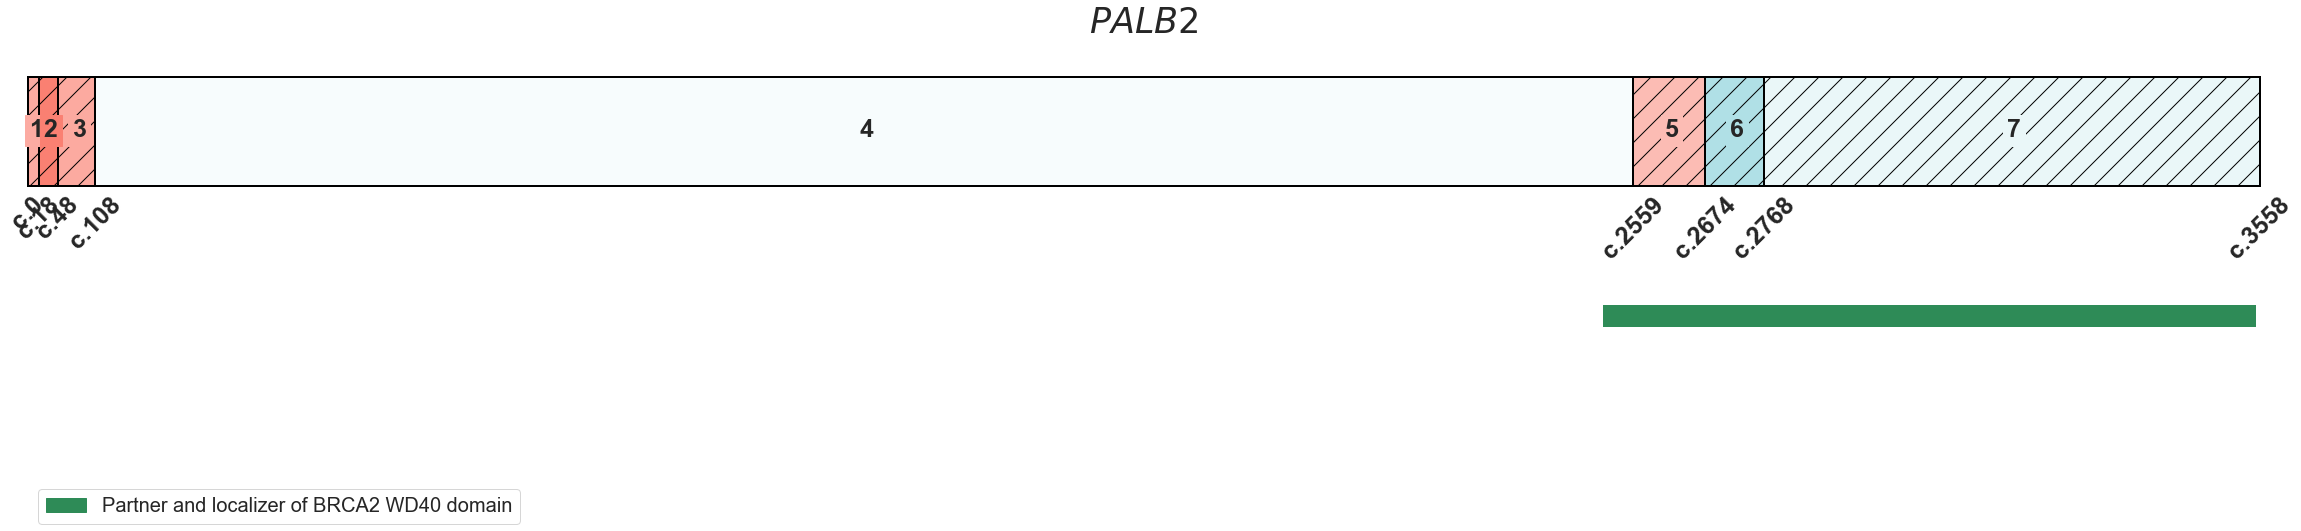

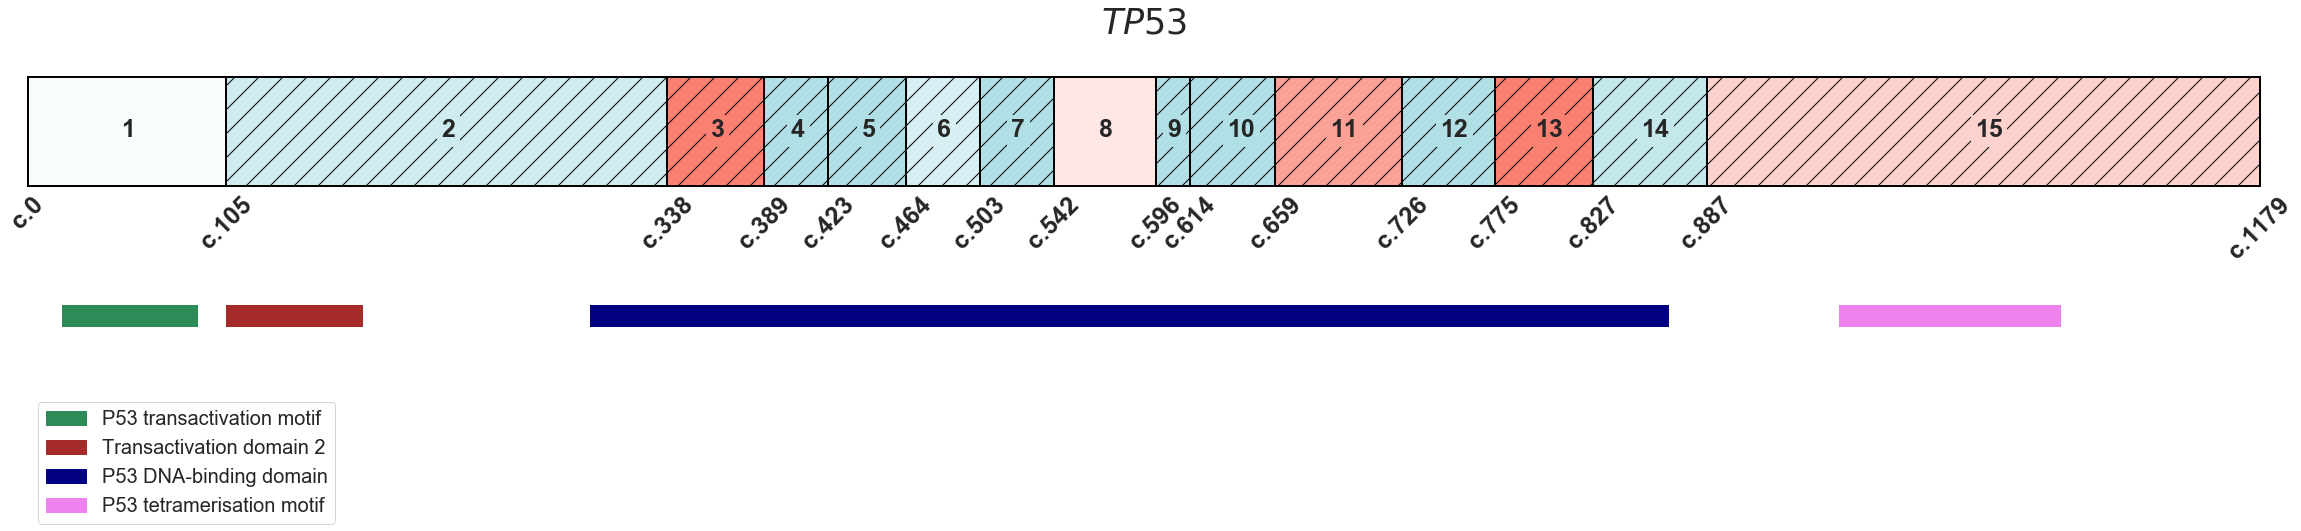

In [30]:
keys = [
    "ATM_15_0.15",
    "BRCA1_15_0.15",
    "BRCA2_15_0.15",
    "CHEK2_11_0.15",
    "MSH6_15_0.15",
    "PALB2_7_0.15",
    "TP53_15_0.15"
]


gene_to_text_offset = {
    "BRCA1" :  20,
    "BRCA2" : 30,
    "CHEK2" : 5,
    "TP53" : 3,
    "MSH6" :19,
    "PALB2" : 7,
    "ATM" : 15
}


for key in keys:
    gene = key.split("_")[0]
    #no chek2 pfam domains 
    if gene == "CHEK2":
        continue

    fig, ax = plt.subplots(figsize = (40,2))

    optimal = logrank_df.loc[logrank_df["key"] == key].iloc[0]
    hr_regions = list(map(lambda x : int(x), optimal["high_regions"].split("|")))
    lr_regions = list(map(lambda x : int(x), optimal["low_regions"].split("|")))
    breakpoints = list(map(lambda x : float(x), optimal["breakpoints"].split("|")))
    breakpoints[-1] = gene_to_end_position[gene]
    dist_offset = 30
    if breakpoints[-1] < 5000:
        dist_offset = 9
        
        
    missense_weight = regression_results.loc[gene]["Missense exp(coef)"]

    cmap = LinearSegmentedColormap.from_list('mycmap', ['powderblue', 'white', 'salmon'])
    norm = Normalize(vmin=-1, vmax=1)

    colors = []
    for j in range(1, optimal["breaks"] + 1):
        v = mega_file[gene][optimal["breaks"]][j]
        weight = np.log2(v["exp(coef)"] / missense_weight)
        min_veight_low = -0.1
        min_weight_high = 0.1
        if weight > min_veight_low and weight < 0:
            weight = min_veight_low
        if weight < min_weight_high and weight > 0:
            weight = min_weight_high
        color =  cmap(norm(weight))
        color_hex = matplotlib.colors.to_hex(color)
        colors.append(color)
    
    make_hr_lr_binary_diagram(
        gene,
        breakpoints, 
        hr_regions, 
        lr_regions, 
        colors,
        dist_offset = gene_to_text_offset[gene], 
        ax = ax, 
        annotate_pfam = True
    )  
    legend = ax.get_legend()
#     legend.set_loc("upper right")
    

#     fig.savefig(f"./high_res_figures/092922_{gene}_with_domains.png", bbox_inches = "tight")

In [31]:



MSH6_df_pfam = get_annotated_pfam_profiles("MSH6", use_preload = False, df = gene_to_df["MSH6"])
MSH6_hr = MSH6_df_pfam.loc[
    (MSH6_df_pfam["to_drop"] == 0) &
    (~MSH6_df_pfam["coding_position"].isna()) &
    (
        ((MSH6_df_pfam["coding_position"] > 1445) & (MSH6_df_pfam["coding_position"] <= 1754)) | 
        ((MSH6_df_pfam["coding_position"] > 2117) & (MSH6_df_pfam["coding_position"] <= 2342)) | 
        ((MSH6_df_pfam["coding_position"] > 3656) & (MSH6_df_pfam["coding_position"] <= 4080))
    )
]

MSH6_hr_pfam = MSH6_hr.loc[MSH6_hr["any domain"] == 1]
MSH6_hr_non_pfam = MSH6_hr.loc[MSH6_hr["any domain"] == 0]

rr1 = risk_ratio(MSH6_hr_pfam, MSH6_hr_non_pfam, return_confidence = True, t = 65)
logrank1 = get_logrank_text( 
     MSH6_hr_pfam["breastcancer_age"].values, 
     MSH6_hr_non_pfam["breastcancer_age"].values,
     MSH6_hr_pfam["breastcancer"].values,
     MSH6_hr_non_pfam["breastcancer"].values
)
print(rr1,logrank1)

pfam_domains = get_pfam_domains("MSH6")
for domain, region_list in pfam_domains.items():
    print(domain, region_list)

(1.2, 0.32, 2.08, 428, 57, [[45, 383], [5, 52]]) $logrank \ p \ = 0.7677$
PWWP domain [[279, 552]]
MutS domain I [[1221, 1578]]
MutS domain II [[1611, 2109]]
MutS domain III [[2214, 3192], [2214, 3192]]
MutS family domain IV [[2796, 3072]]
MutS domain V [[3390, 3972]]


In [32]:
non_pfam_genes = ["CHEK2"]

common_cols = set([
    'old_id', 'sex', 'sex_int', 'bmi', 'breastcancer', 'breastcancer_age',
   'cad', 'cad_age', 'colorectal', 'colorectal_age', 'death', 'death_age',
   'ldl', 'polygenic_cad', 'polygenic_breastcancer', 'polygenic_bmi',
   'sequenced', 'normalized_breastcancer_PRS', 'normalized_cad_PRS',
   'normalized_bmi_PRS', 'normalized_ibd_PRS', 'fh_breastcancer', 'fh_cad',
   'fh_colorectal', 'variant', 'coding_position', 'Missense',
   'Deleterious', 'to_drop', "any domain"
])

keys = [
    "ATM_15_0.15",
    "BRCA1_15_0.15",
    "BRCA2_15_0.15",
    "CHEK2_11_0.15",
    "MSH6_15_0.15",
    "PALB2_7_0.15",
    "TP53_15_0.15"
]   


lst = []
for key in keys:
    gene = key.split("_")[0]
    if gene in non_pfam_genes:
        continue

        
    optimal = logrank_df.loc[logrank_df["key"] == key].iloc[0]
    hr_regions = list(map(lambda x : int(x), optimal["high_regions"].split("|")))
    lr_regions = list(map(lambda x : int(x), optimal["low_regions"].split("|")))
    breakpoints = list(map(lambda x : float(x), optimal["breakpoints"].split("|")))
    breakpoints[-1] = gene_to_end_position[gene]
    
    covered_hr_points = set()
    for h in hr_regions:
        h_start = breakpoints[h-1]
        h_end = breakpoints[h]
        for i in range(int(h_start), int(h_end) + 1):
            covered_hr_points.add(i)
    
        
    pfam_dict = {}
    pfam_domains = get_pfam_domains(gene)
    for domain, region_list in pfam_domains.items():
        pfam_dict[domain] = region_list
    
    print(pfam_domains)
    gene_df_pfam = get_annotated_pfam_profiles(gene, use_preload = False, df = gene_to_df[gene])
    pfam_cols = set(gene_df_pfam.columns).difference(common_cols)
    
    missnese_carriers = gene_df_pfam.loc[
        (gene_df_pfam["to_drop"] == 0) &
        (gene_df_pfam["Deleterious"] == 0) &
        (gene_df_pfam["Missense"] == 1)
    ]
    
    non_pfam_carriers = missnese_carriers.loc[missnese_carriers["any domain"] == 0]
    for c in pfam_cols:
        pfam_domain_points = set()
        domain_carriers = missnese_carriers.loc[missnese_carriers[c] == 1]
        if len(domain_carriers) > 0:
            for vals in pfam_dict[c]:
                for i in range(vals[0], vals[1] + 1):
                    pfam_domain_points.add(i)
                
            
            overlapping_points = pfam_domain_points.intersection(covered_hr_points)
            
            overlap_pct = len(overlapping_points) / len(pfam_domain_points)
            rr1 = risk_ratio(domain_carriers, non_pfam_carriers, return_confidence = True, t = 65)
            
            logrank_text = get_logrank_text( 
                domain_carriers["breastcancer_age"],
                non_pfam_carriers["breastcancer_age"],
                domain_carriers["breastcancer"],
                non_pfam_carriers["breastcancer"],
            )
            
            if rr1 is None:
                continue

            
            lst.append([
                gene,
                c,
                rr1[0],
                rr1[1],
                rr1[2],
                overlap_pct,
                logrank_text.replace("$", "").replace(" ", "").split("=")[1].replace("{", "").replace("}","").replace("^","e"),
                len(domain_carriers)
            ])

pfam_df = pd.DataFrame(lst, columns = ["gene", "domain", "rr", "rr lower 95", "rr upper 95", "overlap with hr", "logrank", "carriers"])


# pfam_df.to_csv("010422_pfam_domain_weights.csv")

{'Telomere-length maintenance and DNA damage repair': [[24, 495]], 'FAT domain': [[6288, 7467]], 'Phosphatidylinositol 3- and 4-kinase': [[8139, 8886]], 'FATC domain': [[9075, 9168]]}
{'Zinc finger, C3HC4 type (RING finger)': [[72, 192]], 'Serine-rich domain associated with BRCT': [[1035, 1524]], 'BRCA1 C Terminus (BRCT) domain': [[4926, 5169], [5268, 5526]]}
{'BRCA2 repeat': [[3015, 3099], [3645, 3729], [4272, 4356], [4560, 4644], [5001, 5085], [5922, 6006], [6162, 6246]], 'BRCA2, helical': [[7443, 8001]], 'BRCA2, oligonucleotide/oligosaccharide-binding, domain 1': [[8010, 8388]], 'Tower': [[8493, 8616]], 'BRCA2, oligonucleotide/oligosaccharide-binding, domain 3': [[9156, 9558]]}
{'PWWP domain': [[279, 552]], 'MutS domain I': [[1221, 1578]], 'MutS domain II': [[1611, 2109]], 'MutS domain III': [[2214, 3192], [2214, 3192]], 'MutS family domain IV': [[2796, 3072]], 'MutS domain V': [[3390, 3972]]}
{'Partner and localizer of BRCA2 WD40 domain': [[2511, 3552]]}
{'P53 transactivation motif

In [33]:
pfam_df

,gene,domain,rr,rr lower 95,rr upper 95,overlap with hr,logrank,carriers
0,ATM,Telomere-length maintenance and DNA damage repair,0.62,-0.34,1.57,0.000000,0.3742,140
1,ATM,FATC domain,0.46,-0.65,1.57,0.000000,0.1152,133
2,ATM,Phosphatidylinositol 3- and 4-kinase,0.52,-0.27,1.31,0.000000,0.1546,209
3,ATM,FAT domain,1.12,0.80,1.45,1.000000,0.0562,623
4,BRCA1,"Zinc finger, C3HC4 type (RING finger)",5.86,4.87,6.86,1.000000,9.32x10e-7,12
5,BRCA1,BRCA1 C Terminus (BRCT) domain,1.19,0.51,1.87,0.322068,0.5011,193
6,BRCA1,Serine-rich domain associated with BRCT,0.72,0.12,1.32,0.000000,0.8631,355
7,BRCA2,"BRCA2, oligonucleotide/oligosaccharide-binding...",0.85,0.35,1.35,0.583113,0.9663,413
8,BRCA2,Tower,1.31,0.23,2.38,0.258065,0.1226,64
9,BRCA2,"BRCA2, helical",1.06,0.57,1.54,0.220036,0.4031,376


In [34]:
msh6_hr_covered = [
    [1445, 1754],
    [2117, 2342],
    [3656, 4080]
]

MSH6_domains = [
    [279, 552],
    [1221, 1578], # MutS 1
    [1611, 2109],
    [2214, 3192],
    [2511, 3552],
    [2796, 3072],
    [3390, 3972]
]

hr_covered_bases = set()
for pair in msh6_hr_covered:
    for i in range(pair[0], pair[1]):
        hr_covered_bases.add(i)
        
covered_pfam_points = set()
uncovered_pfam_points = set()

for pair in MSH6_domains:
    for i in range(pair[0], pair[1]):
        if i in hr_covered_bases:
            covered_pfam_points.add(i)
        else:
            uncovered_pfam_points.add(i)


print(len(hr_covered_bases))
print(len(covered_pfam_points), len(uncovered_pfam_points))

print(len(covered_pfam_points) / len(hr_covered_bases))

print("muts i ", (1445 - 1221) / (1578 - 1221))
print("muts v",  1-((3656 - 3390) / (3972 - 3390)))

BRCA1_pfam = get_annotated_pfam_profiles("BRCA1", use_preload = False, df = gene_to_df["BRCA1"])

r1_r2 = [0,287]
ring_coords = [72, 192]

print("RING ")
BRCA1_pfam["in 1_2 not ring"] = BRCA1_pfam["coding_position"].apply(
    lambda x : (x > r1_r2[0] and x <= r1_r2[1] ) and (x < ring_coords[0] or x >= ring_coords[1])
)

reg_1_2_non_ring = BRCA1_pfam.loc[BRCA1_pfam["in 1_2 not ring"]]
BRCA1_non_carriers = BRCA1_pfam.loc[(BRCA1_pfam["Missense"] == 0) & (BRCA1_pfam["Deleterious"] == 0)]

rr = risk_ratio(reg_1_2_non_ring, BRCA1_non_carriers, return_confidence = True, t = 65)

logrank_text = get_logrank_text(
    reg_1_2_non_ring["breastcancer_age"],
    BRCA1_non_carriers["breastcancer_age"],
    reg_1_2_non_ring["breastcancer"],
    BRCA1_non_carriers["breastcancer"]
)

print(rr)
print(logrank_text, len(reg_1_2_non_ring["breastcancer_age"]))


ATM_pfam = get_annotated_pfam_profiles("ATM", use_preload = False, df = gene_to_df["ATM"])
ATM_FAT_carriers = ATM_pfam.loc[ATM_pfam["FAT domain"] == 1]
FAT_locs = [6288, 7467]
ATM_HR_regions = [5228, 7997]

ATM_region_non_FAT = ATM_pfam.loc[
    (ATM_pfam["coding_position"] > ATM_HR_regions[0]) & 
    (ATM_pfam["coding_position"] <= ATM_HR_regions[1]) &
    (ATM_pfam["FAT domain"] == 0) 
]
ATM_non_carriers = ATM_pfam.loc[(ATM_pfam["Missense"] == 0) & (ATM_pfam["Deleterious"] == 0)]

rr = risk_ratio(ATM_region_non_FAT, ATM_non_carriers, return_confidence = True, t = 65)

logrank_text = get_logrank_text(
    ATM_region_non_FAT["breastcancer_age"],
    ATM_non_carriers["breastcancer_age"],
    ATM_region_non_FAT["breastcancer"],
    ATM_non_carriers["breastcancer"]
)

print(rr)
print(logrank_text, len(reg_1_2_non_ring["breastcancer_age"]))


958
720 2166
0.7515657620041754
muts i  0.6274509803921569
muts v 0.5429553264604812
RING 
(2.51, 1.64, 3.37, 18, 51734, [[4, 14], [4582, 47152]])
$logrank \ p \ = 0.0993$ 33
(1.39, 1.15, 1.63, 485, 49968, [[59, 426], [4374, 45594]])
$logrank \ p \ = 0.0039$ 33


In [35]:
1 - ( (len(MSH6_hr_non_pfam) / (len(MSH6_hr_pfam) + len(MSH6_hr_non_pfam))))

0.8784473953013279

In [36]:
df = pd.read_csv("OR_conditions_fig_3.csv")
vals = []
for g in set(df["gene"]):
    v1 = df.loc[(df["gene"] == g) & (df["condition"] == "HR/LR")].iloc[0]["O.R."]
    v2 = df.loc[(df["gene"] == g) & (df["condition"] == "Mis/NC")].iloc[0]["O.R."]
    vals.append(v1/v2)
    
mean_confidence_interval(vals)

(2.1913852456718472, 1.4833274983539173, 2.899442992989777)